<a href="https://colab.research.google.com/github/arizonaCameraLab/computationalImaging/blob/master/Chapter10SamplingStrategy/phasedDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# Phased array detectors
## David Brady
## University of Arizona
## October 2024


We consider coupled coherent detectors for incoherent optical imaging. First we consider two mode detection of two point sources, at positions $x_1$ and $x_2$.

Expressed on the object space, the modes are $\psi(x)$ and $\phi(x)$. The mutual intensity due to a point source at position $x_o$ in the input space is
$$\bf{J}=
\begin{pmatrix}
|\psi (x_o)|^2&\psi(x_o)\phi^\ast(x_o)\\
\psi^\ast(x_o)\phi(x_o)&|\phi(x_o)|^2\\
\end{pmatrix}
$$
The mutual intensity for the two point sources is the sum of their individual mutual intensities
$$\bf{J}=
\begin{pmatrix}
|\psi (x_1)|^2+|\psi (x_2)|^2&\psi(x_1)\phi^\ast(x_1)+\psi(x_2)\phi^\ast(x_2)\\
\psi^\ast(x_1)\phi(x_1)+\psi^\ast(x_2)\phi(x_2)&|\phi(x_1)|^2+|\phi(x_2)|^2\\
\end{pmatrix}
$$
In analysis below we parameterize the system as $x_1=x_0+\delta$ and $x_2=x_o-\delta$.

Assume that

$$\psi(x_1)\approx \psi (x_0)+ \delta \frac{d\psi(x_0)}{dx}$$
$$\phi(x_1)\approx \phi (x_0)+ \delta \frac{d\phi(x_0)}{dx}$$

As an example, the $\phi(x)$ and $\psi(x)$ are defined as normal distributions with variance 1, but different means:
$$
\phi(x) = \frac{1}{\sqrt{2\pi}} e^{-(x + 0.5)^2 / 2}, \quad \psi(x) = \frac{1}{\sqrt{2\pi}} e^{-(x - 0.5)^2 / 2}
$$

Evaluating these functions at $ x_0$, we define:
$$
a = \psi(x_0) = \frac{1}{\sqrt{2\pi}} e^{-(x_0 - 0.5)^2 / 2}, \quad c = \phi(x_0) = \frac{1}{\sqrt{2\pi}} e^{-(x_0 + 0.5)^2 / 2}
$$

The derivatives of $\phi$ and $\psi$ with respect to $x$ at $x = x_0$
 are:
$$
b = \frac{d \psi}{dx} \Big|_{x = x_0} = -\frac{(x_0 - 0.5)}{\sqrt{2\pi}} e^{-(x_0 - 0.5)^2 / 2}
$$
$$
d = \frac{d \phi}{dx} \Big|_{x = x_0} = -\frac{(x_0 + 0.5)}{\sqrt{2\pi}} e^{-(x_0 + 0.5)^2 / 2}
$$

Mutual intensity matrices for each point source $J$ and $K$ are defined as:
$$
J =\begin{bmatrix} (a + \delta b)^2 & (a + \delta b)(c + \delta d) \\ (a + \delta b)(c + \delta d) & (c + \delta d)^2 \end{bmatrix}, \quad K = \begin{bmatrix} (a - \delta b)^2 & (a - \delta b)(c - \delta d) \\ (a - \delta b)(c - \delta d) & (c - \delta d)^2 \end{bmatrix}
$$

The joint mutual intensity $J + K$ is
$$
J + K = \begin{bmatrix} 2a^2 + 2\delta^2 b^2 & 2ac + 2\delta^2 bd \\ 2ac + 2\delta^2 bd & 2c^2 + 2\delta^2 d^2 \end{bmatrix}
$$

Letting $A = 2a^2 + 2\delta^2 b^2$, $B = 2ac + 2\delta^2 bd$, and $C = 2c^2 + 2\delta^2 d^2$, we rewrite $J + K$ as:
$$
J + K = \begin{bmatrix} A & B \\ B & C \end{bmatrix}
$$

The eigenvalues $\lambda_1$ and $\lambda_2$ of $J + K$ are given by:
$$
\lambda_{1,2} = \frac{A + C}{2} \pm \frac{\sqrt{(A + C)^2 - 4(AC - B^2)}}{2}
$$

The term $AC - B^2$ can be simplified to:
$$
AC - B^2 = 4\delta^2 \left(a^2 d^2 + b^2 c^2 - ab \cdot cd\right)
$$

Expanding the square root term in a Taylor series around $\delta^2 $, the eigenvalues become:
$$
\lambda_1 \approx 2(a^2 + c^2) - \frac{\delta^2 (a^2 d^2 + b^2 c^2 - ab \cdot cd)}{a^2 + c^2}
$$
$$
\lambda_2 \approx \frac{\delta^2 (a^2 d^2 + b^2 c^2 - ab \cdot cd)}{a^2 + c^2}
$$

### Key Observation
The eigenvalue $\lambda_2$ is proportional to $\delta^2$.



## libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from sklearn.decomposition import PCA
import cv2
def derivative_sinc(x):
    # Handle the point x = 0 separately to avoid division by zero
    if x == 0:
        return 0
    else:
        return (np.pi*x * np.cos(np.pi*x) - np.sin(np.pi*x)) / ((np.pi**(3/2)) * x**2)
dsinc=np.vectorize(derivative_sinc)
plt.rcParams.update({'font.size': 22})

## Sinc impulse response example


Assume that $\psi(x)={\rm sinc}(x)$, $\phi(x)={\rm sinc}(x-1)$.

In [ ]:
def j(x,delta):
  j=np.zeros((2,2))
  ps1=np.sinc(x-delta)
  ph1=np.sinc(x-delta-1)
  ps2=np.sinc(x+delta)
  ph2=np.sinc(x+delta-1)
  j[0,0]=ps1**2+ps2**2
  j[0,1]=ps1*ph1+ps2*ph2
  j[1,0]=ps1*ph1+ps2*ph2
  j[1,1]=ph1**2+ph2**2
  return j
def lam(x,delta):
  u, s,v=np.linalg.svd(j(x,delta))
  return s[1]
def lam0(x,delta):
  u, s,v=np.linalg.svd(j(x,delta))
  return s[0]
lamv=np.vectorize(lam)
lam0v=np.vectorize(lam0)

In [ ]:
u, s,v=np.linalg.svd(j(.5,0.1))

In [ ]:
print(s)

[1.59107416 0.06364297]


In [ ]:
print(j(0.1,0.1))

[[1.8751402  0.21878505]
 [0.21878505 0.05469626]]


Text(0, 0.5, '$\\lambda_0$')

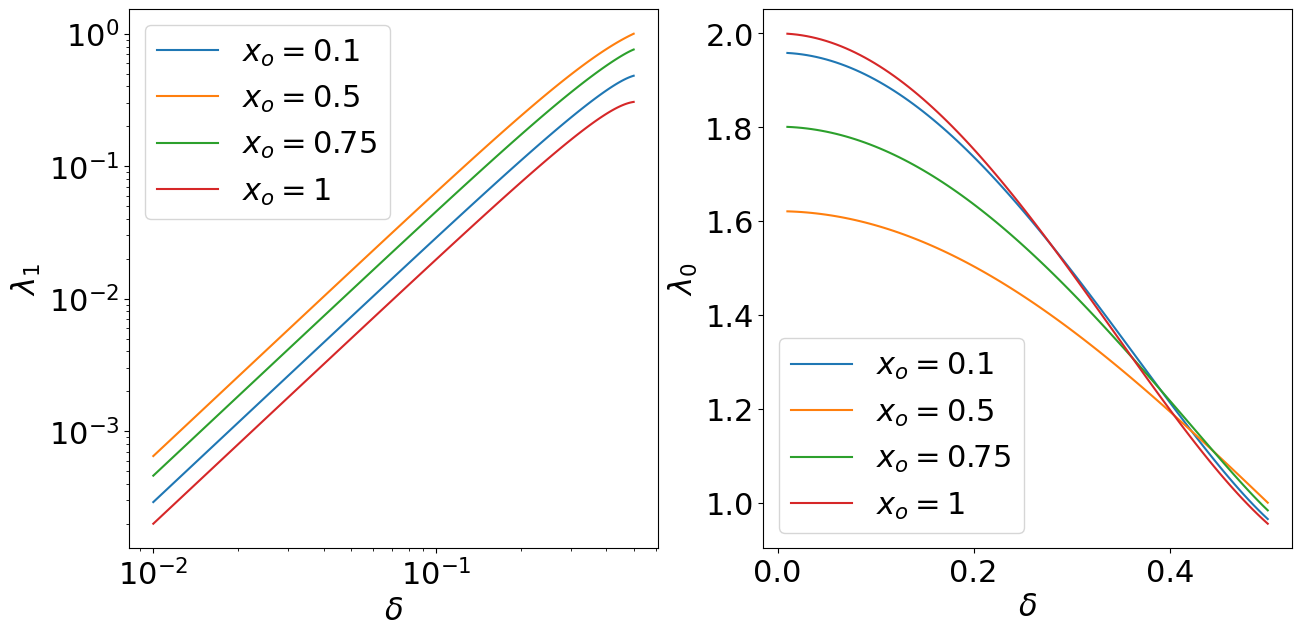

In [ ]:
plt.figure(figsize=(15,7))
delta=np.linspace(0.01,.5,100)
plt.subplot(1,2,1)
plt.loglog(delta,lamv(0.1,delta))
plt.loglog(delta,lamv(0.5,delta))
plt.loglog(delta,lamv(.75,delta))
plt.loglog(delta,lamv(1,delta))
plt.legend(['$x_o=0.1$','$x_o=0.5$','$x_o=0.75$','$x_o=1$'])
plt.xlabel(r'$\delta$')
plt.ylabel(r'$\lambda_1$')
plt.subplot(1,2,2)
plt.plot(delta,lam0v(0.1,delta))
plt.plot(delta,lam0v(0.5,delta))
plt.plot(delta,lam0v(.75,delta))
plt.plot(delta,lam0v(1,delta))
plt.legend(['$x_o=0.1$','$x_o=0.5$','$x_o=0.75$','$x_o=1$'])
plt.xlabel(r'$\delta$')
plt.ylabel(r'$\lambda_0$')

Text(0, 0.5, '$\\lambda_1$')

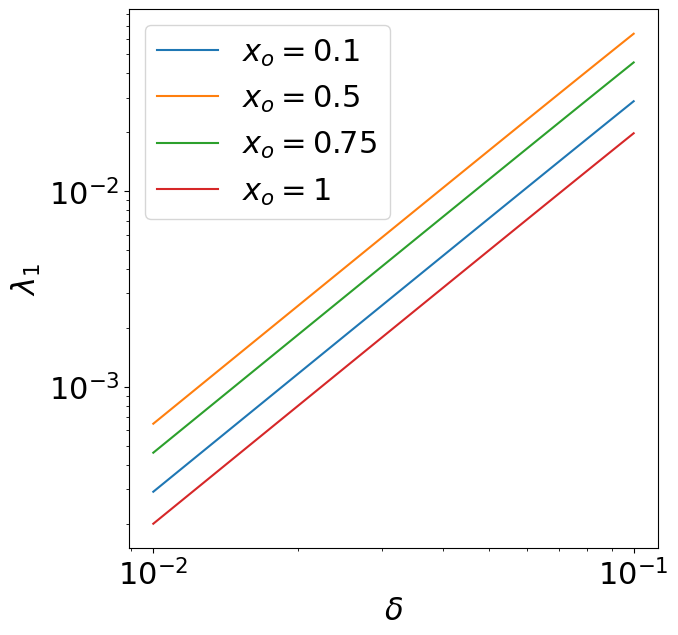

In [ ]:
plt.figure(figsize=(15,7))
delta=np.linspace(0.01,.1,100)
plt.subplot(1,2,1)
plt.loglog(delta,lamv(0.1,delta))
plt.loglog(delta,lamv(0.5,delta))
plt.loglog(delta,lamv(.75,delta))
plt.loglog(delta,lamv(1,delta))
plt.legend(['$x_o=0.1$','$x_o=0.5$','$x_o=0.75$','$x_o=1$'])
plt.xlabel(r'$\delta$')
plt.ylabel(r'$\lambda_1$')

## Guassian impulse repsonse example


Assume that $\psi(x)=\frac{1}{\sqrt{\sigma \sqrt{2\pi}}}e^{-\frac{(x-.5\sigma )^2}{4\sigma^2}}$, $\phi(x)=\frac{1}{\sqrt{\sigma \sqrt{2\pi}}}e^{-\frac{(x+.5\sigma )^2}{4\sigma^2}}$.

In [ ]:

def gaus(x, mean=0, std_dev=1):
  """
  Args:
    x: The value at which to calculate the probability density.
    mean: The mean of the distribution.
    std_dev: The standard deviation of the distribution.

  """
  exponent = -((x - mean) ** 2) / (4* (std_dev ** 2))
  coefficient = 1 / np.sqrt(std_dev * np.sqrt(2 * np.pi))
  return coefficient * np.exp(exponent)



In [ ]:
def j(x,delta):
  j=np.zeros((2,2))
  ps1=gaus(x-delta-.5)
  ph1=gaus(x-delta+.5)
  ps2=gaus(x+delta-.5)
  ph2=gaus(x+delta+.5)
  j[0,0]=ps1**2+ps2**2
  j[0,1]=ps1*ph1+ps2*ph2
  j[1,0]=ps1*ph1+ps2*ph2
  j[1,1]=ph1**2+ph2**2
  return j
def lam(x,delta):
  u, s,v=np.linalg.svd(j(x,delta))
  return s[1]
def lam0(x,delta):
  u, s,v=np.linalg.svd(j(x,delta))
  return s[0]
lamv=np.vectorize(lam)
lam0v=np.vectorize(lam0)

In [ ]:
u, s,v=np.linalg.svd(j(.5,0.1))

In [ ]:
print(s)

[1.40115542 0.0075544 ]


In [ ]:
print(j(0.1,0.1))

[[0.73345314 0.69715929]
 [0.69715929 0.66431926]]


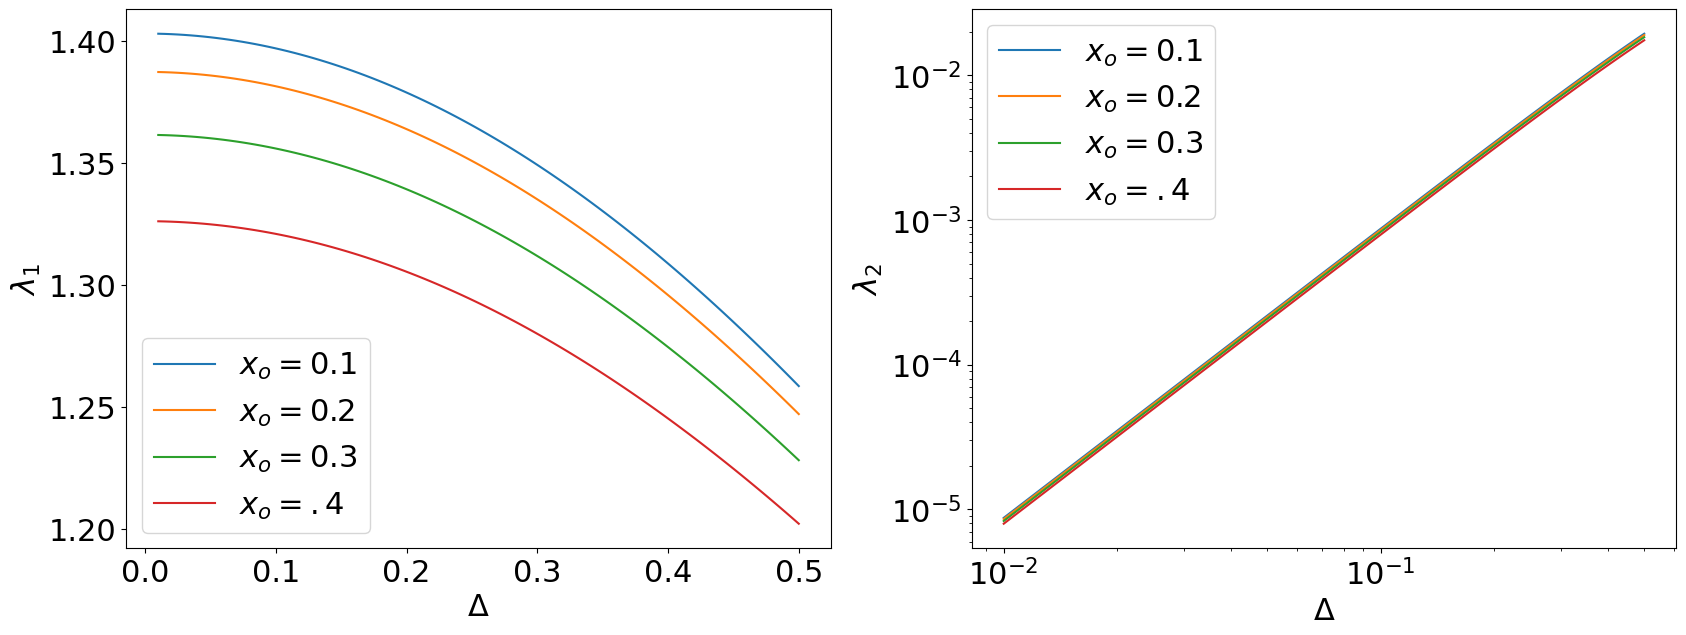

In [ ]:
plt.figure(figsize=(20,7))
delta=np.linspace(0.01,.5,100)
plt.subplot(1,2,2)
plt.loglog(delta,lamv(0.1,delta))
plt.loglog(delta,lamv(0.2,delta))
plt.loglog(delta,lamv(.3,delta))
plt.loglog(delta,lamv(.4,delta))
plt.legend(['$x_o=0.1$','$x_o=0.2$','$x_o=0.3$','$x_o=.4$'])
plt.xlabel(r'$\Delta$')
plt.ylabel(r'$\lambda_2$')
plt.subplot(1,2,1)
plt.plot(delta,lam0v(0.1,delta))
plt.plot(delta,lam0v(0.2,delta))
plt.plot(delta,lam0v(.3,delta))
plt.plot(delta,lam0v(.4,delta))
plt.legend(['$x_o=0.1$','$x_o=0.2$','$x_o=0.3$','$x_o=.4$'])
plt.xlabel(r'$\Delta$')
plt.ylabel(r'$\lambda_1$')
plt.savefig('2ptEigenValues.pdf')

Text(0, 0.5, '$\\lambda_1$')

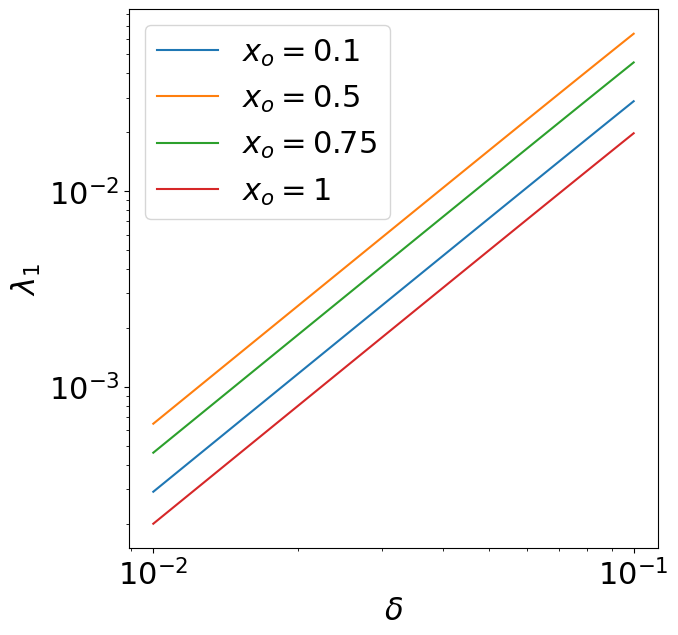

In [ ]:
plt.figure(figsize=(15,7))
delta=np.linspace(0.01,.1,100)
plt.subplot(1,2,1)
plt.loglog(delta,lamv(0.1,delta))
plt.loglog(delta,lamv(0.5,delta))
plt.loglog(delta,lamv(.75,delta))
plt.loglog(delta,lamv(1,delta))
plt.legend(['$x_o=0.1$','$x_o=0.5$','$x_o=0.75$','$x_o=1$'])
plt.xlabel(r'$\delta$')
plt.ylabel(r'$\lambda_1$')

## Discrete forward model for 1D coherence sensors

We compare forward models for sensors that detect the irradiance for with coherent impulse response $h(x)$ with coherence sensors that detect discrete samples of the coherence function. An impulse at position $x_o$ produces the signal $|h(x-x_o)|^2$ for the conventional system. The impulse response for coherence system measures $|h(x-x_o)|^2$ and $h(x-x_o)h(x-x_o+\Delta)$ for specific values of $\Delta$.

We begin with the assumption that $h(x)={\rm sinc}(x)$. We compare sampling ${\rm sinc}^2(x)$ with sampling period $0.5$ with sampling ${\rm sinc}^2(x)$ with sampling period 1 and ${\rm sinc}(x){\rm sinc(x-1)}$ with sampling period 1.

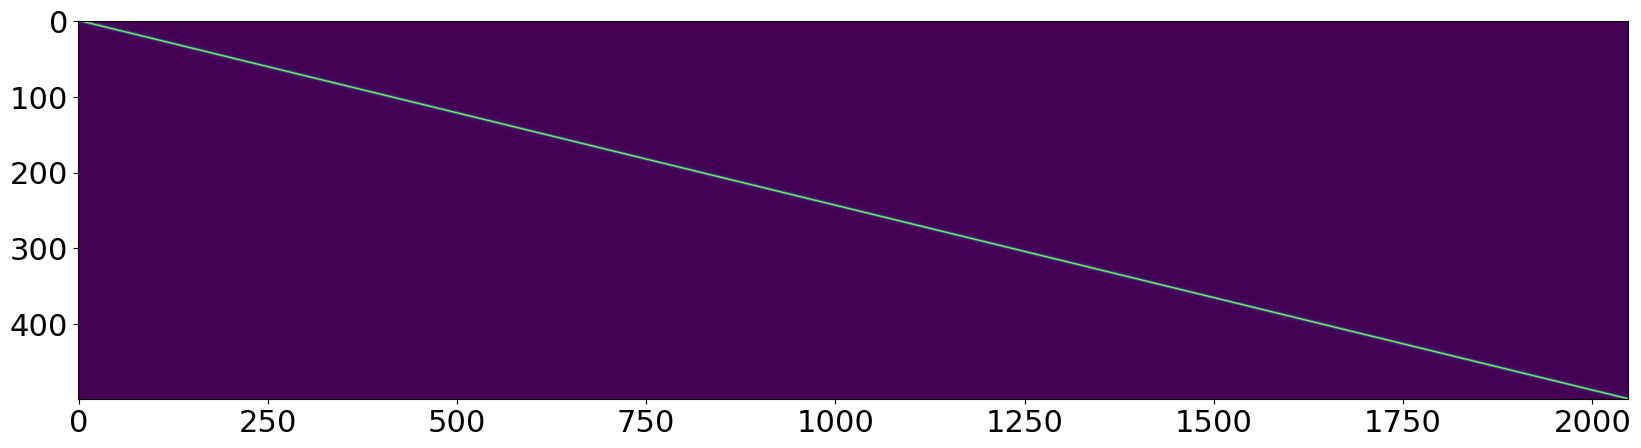

In [ ]:
#
# here we consider a system with impulse response sinc^2(x) sampled 10 times per sinc
#
x=np.linspace(-100,100,2048)
xo=np.linspace(-100,100,500)
xin, xout=np.meshgrid(x,xo)
hc=np.sinc(xin-xout)**2
plt.figure(figsize=(20,10))
plt.imshow(hc)
u, lc, vc=np.linalg.svd(hc)


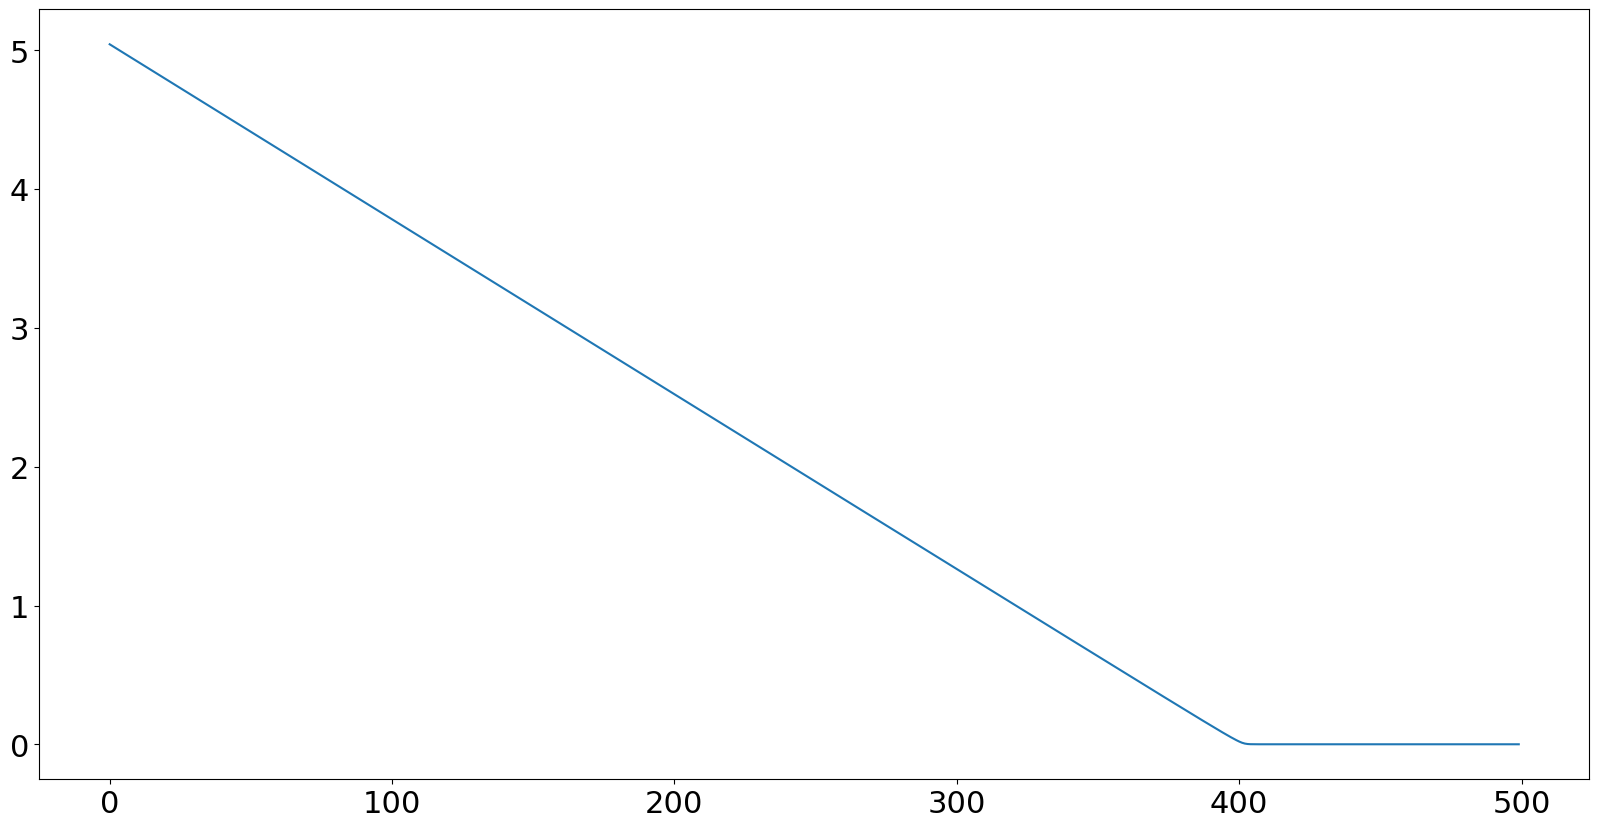

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(lc)

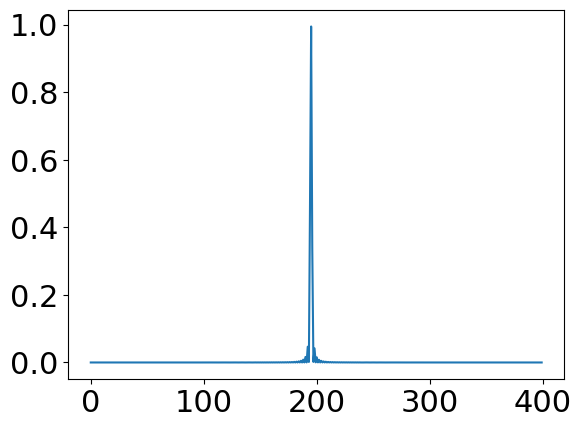

In [ ]:
plt.plot(h[:,1000])

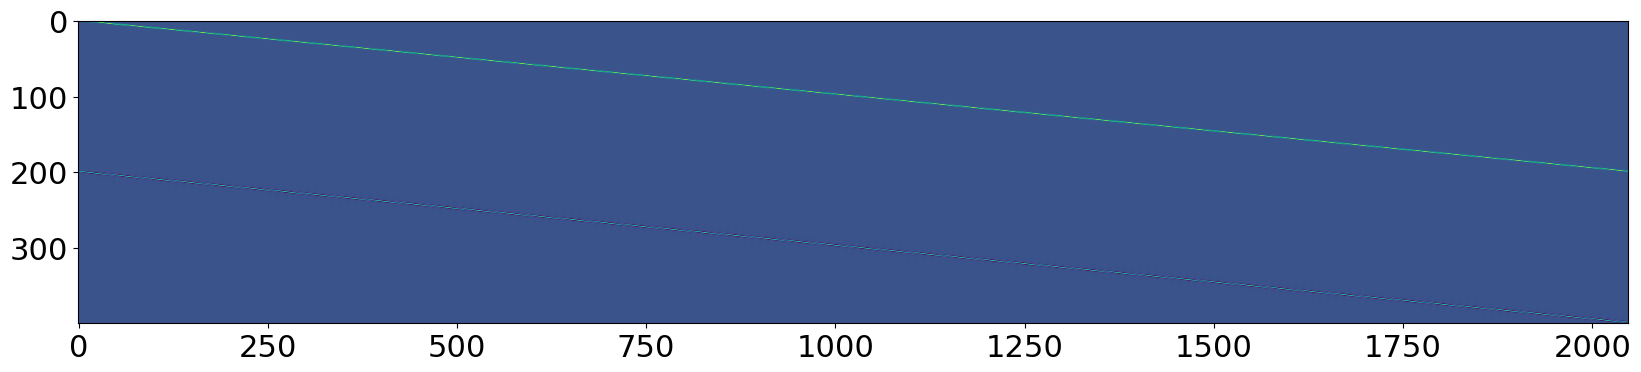

In [ ]:
x=np.linspace(-100,100,2048)
xo=np.linspace(-100,100,200)
xin, xout=np.meshgrid(x,xo)
h=np.sinc(xin-xout)**2
h1=2*np.sinc(xin-xout)*np.sinc(xin-xout-1)
hh=np.vstack((h,h1))
plt.figure(figsize=(20,10))
plt.imshow(hh)
u, li, vi=np.linalg.svd(hh)

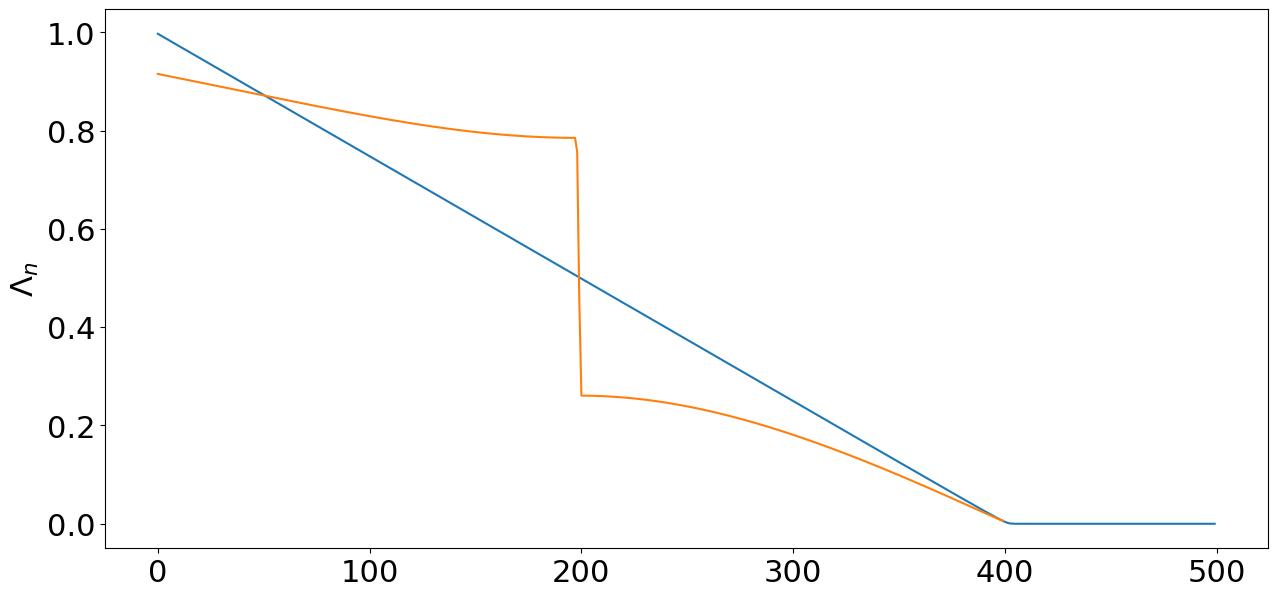

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(200*lc/np.sum(lc))
plt.plot(200*li/np.sum(li))
plt.ylabel(r'$\Lambda_n$')
plt.savefig('1DJEigenValues.pdf')

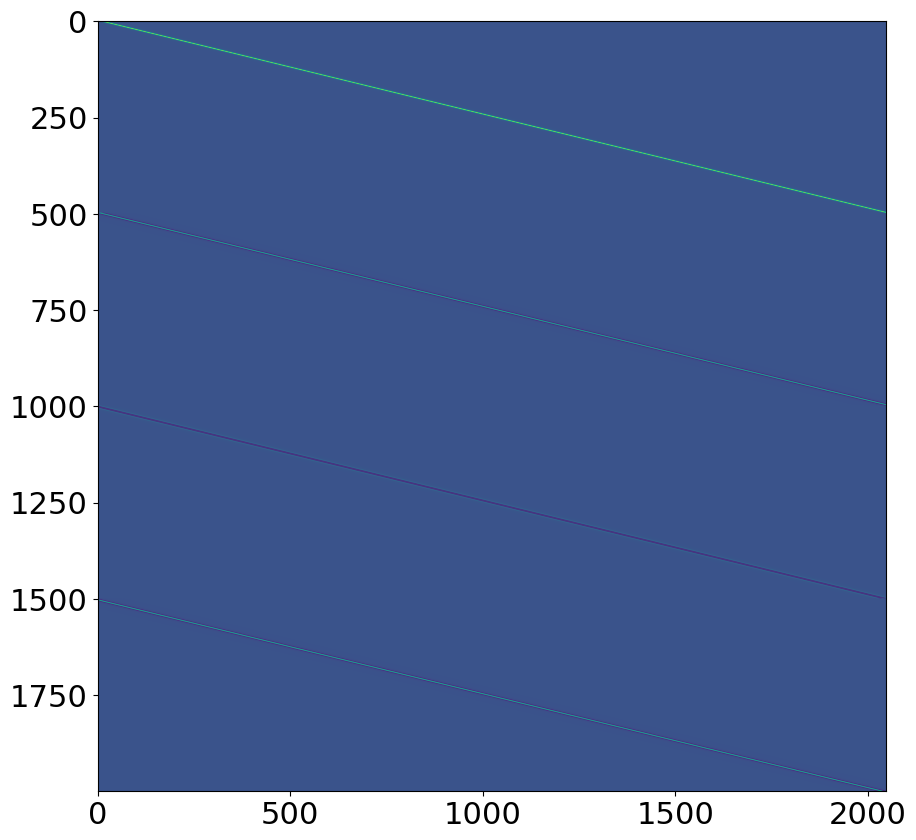

In [ ]:
x=np.linspace(-100,100,2048)
xo=np.linspace(-100,100,500)
xin, xout=np.meshgrid(x,xo)
h=np.sinc(xin-xout)**2
h1=2*np.sinc(xin-xout)*np.sinc(xin-xout-1)
h2=2*np.sinc(xin-xout)*np.sinc(xin-xout+2)
h3=2*np.sinc(xin-xout+1)*np.sinc(xin-xout+2)
hhh=np.vstack((np.vstack((np.vstack((h,h1)),h2)),h3))
plt.figure(figsize=(20,10))
plt.imshow(hhh)
u, lii, vii=np.linalg.svd(hhh)

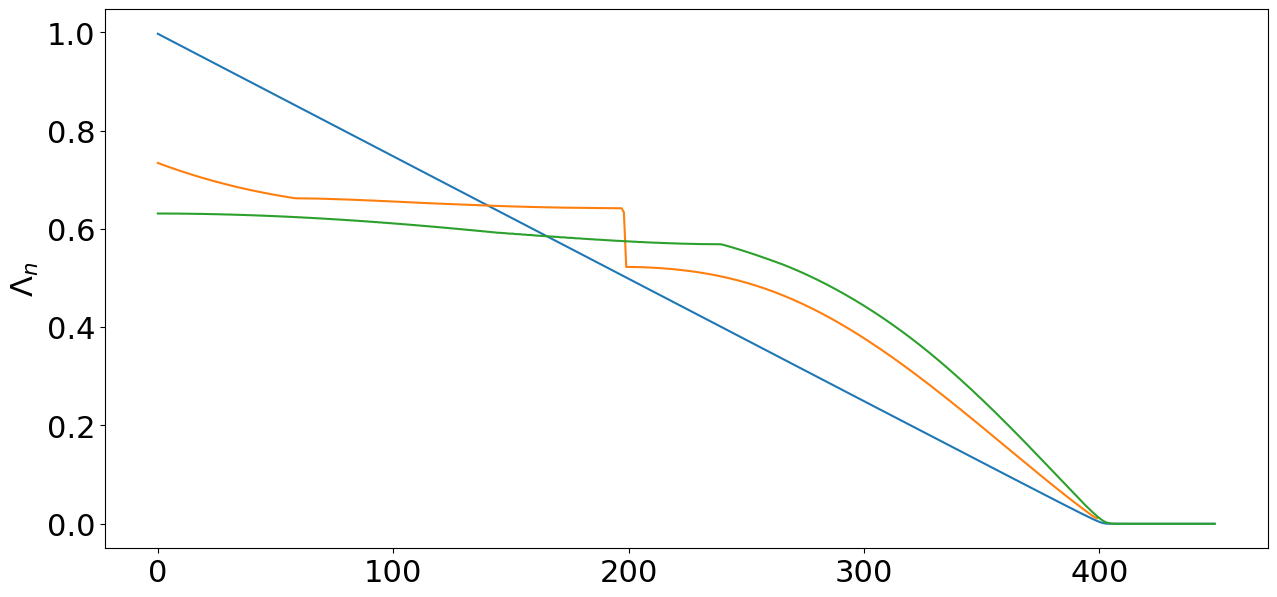

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(200*lc[0:450]/np.sum(lc))
plt.plot(200*li[0:450]/np.sum(li))
plt.plot(200*lii[0:450]/np.sum(lii))
plt.ylabel(r'$\Lambda_n$')
plt.savefig('1DJEigenValues.pdf')

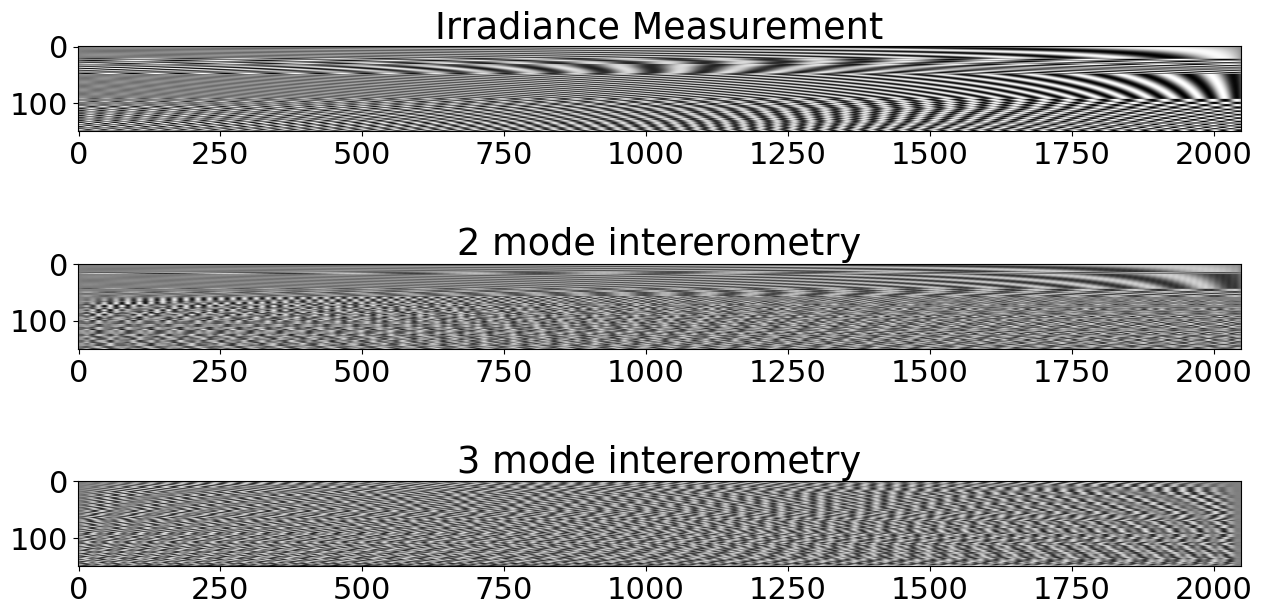

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot(3,1,1)
plt.imshow(vc[:150,:], cmap='binary')
plt.title('Irradiance Measurement')
plt.subplot(3,1,2)
plt.imshow(vi[:150,:], cmap='binary')
plt.title('2 mode intererometry')
plt.subplot(3,1,3)
plt.imshow(vii[:150,:], cmap='binary')
plt.title('3 mode intererometry')
plt.savefig('1DJEigenVectors.pdf')

## Imaging estimation

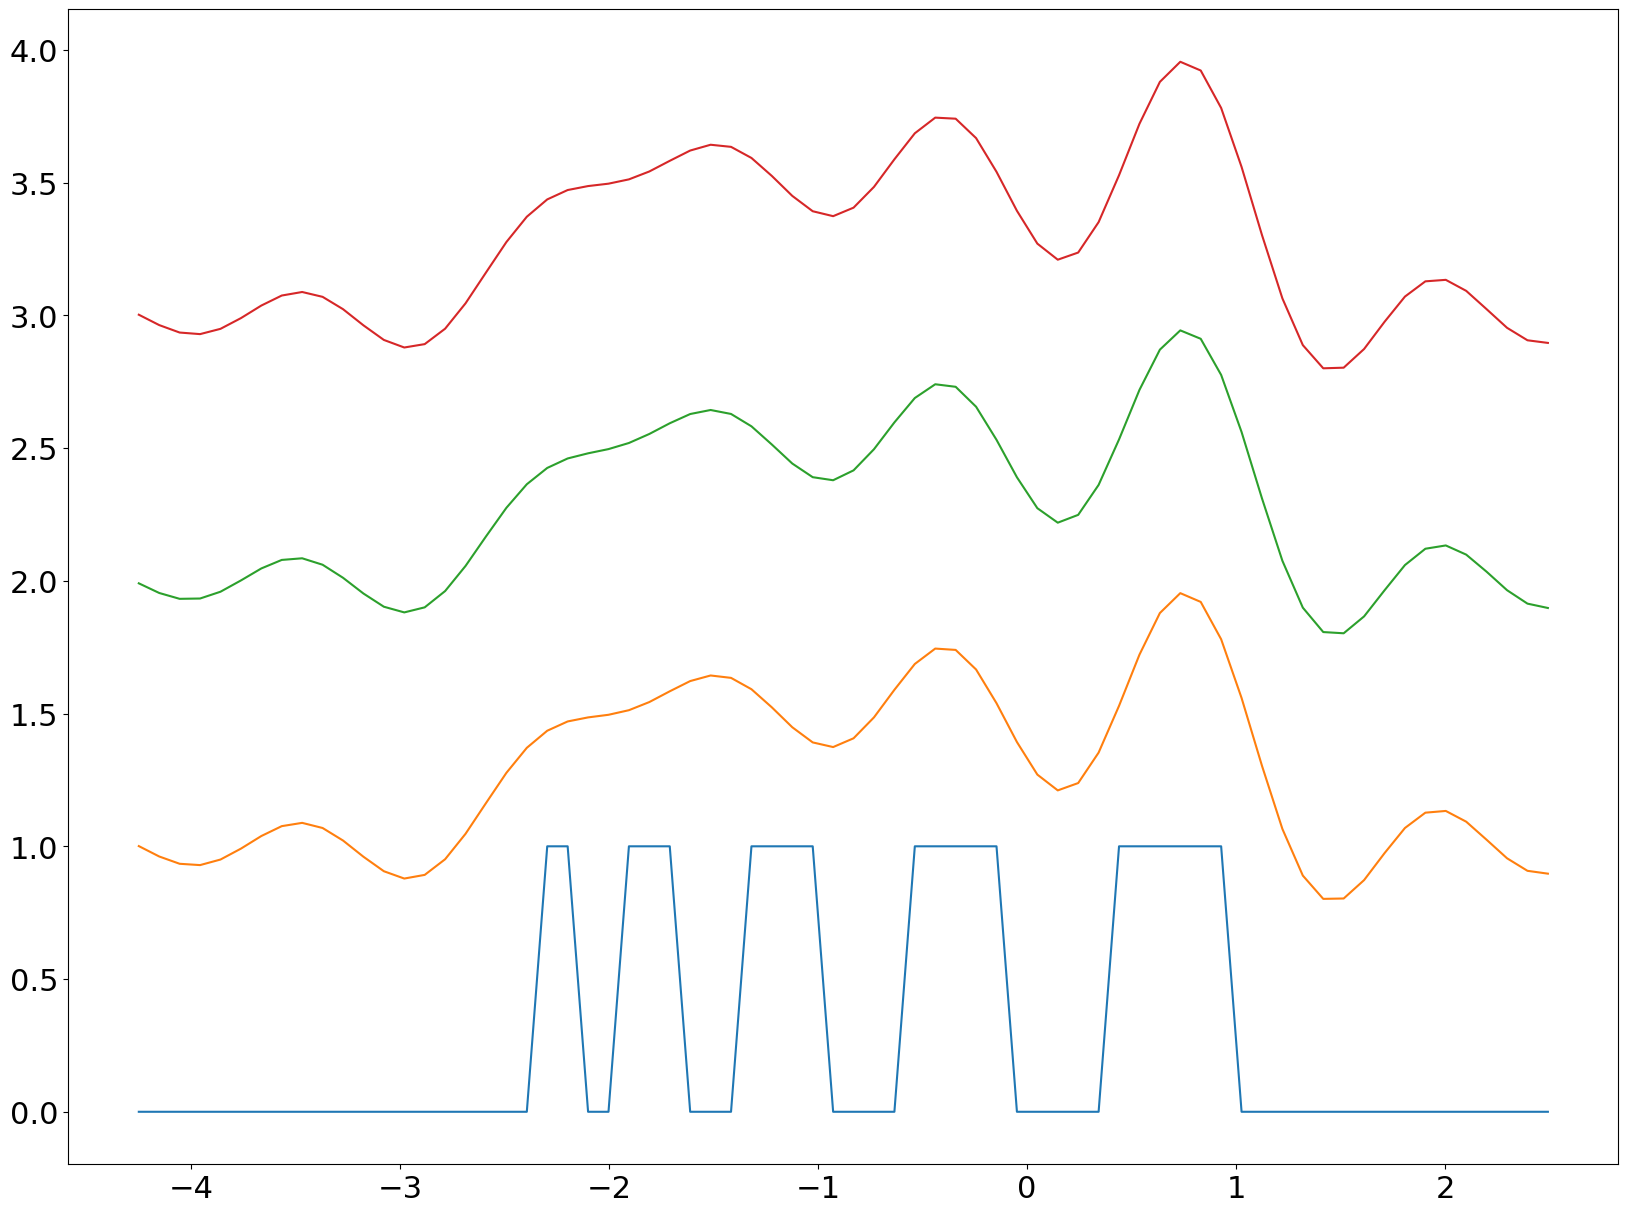

In [ ]:

plt.figure(figsize=(20,15))
x = np.linspace(-100, 100, 2048)
xin, xout = np.meshgrid(x, x)
f=np.zeros(2048)
f[1000:1002]=1
f[1004:1007]=1
f[1010:1014]=1
f[1018:1023]=1
f[1028:1034]=1
plt.plot(x[980:1050],f[980:1050])
plt.plot(x[980:1050],(np.linalg.lstsq(hc,hc@f,rcond=.001)[0])[980:1050]+1)
plt.plot(x[980:1050],(np.linalg.lstsq(hh,hh@f,rcond=.001)[0])[980:1050]+2)
plt.plot(x[980:1050],(np.linalg.lstsq(hhh,hhh@f,rcond=.001)[0])[980:1050]+3)


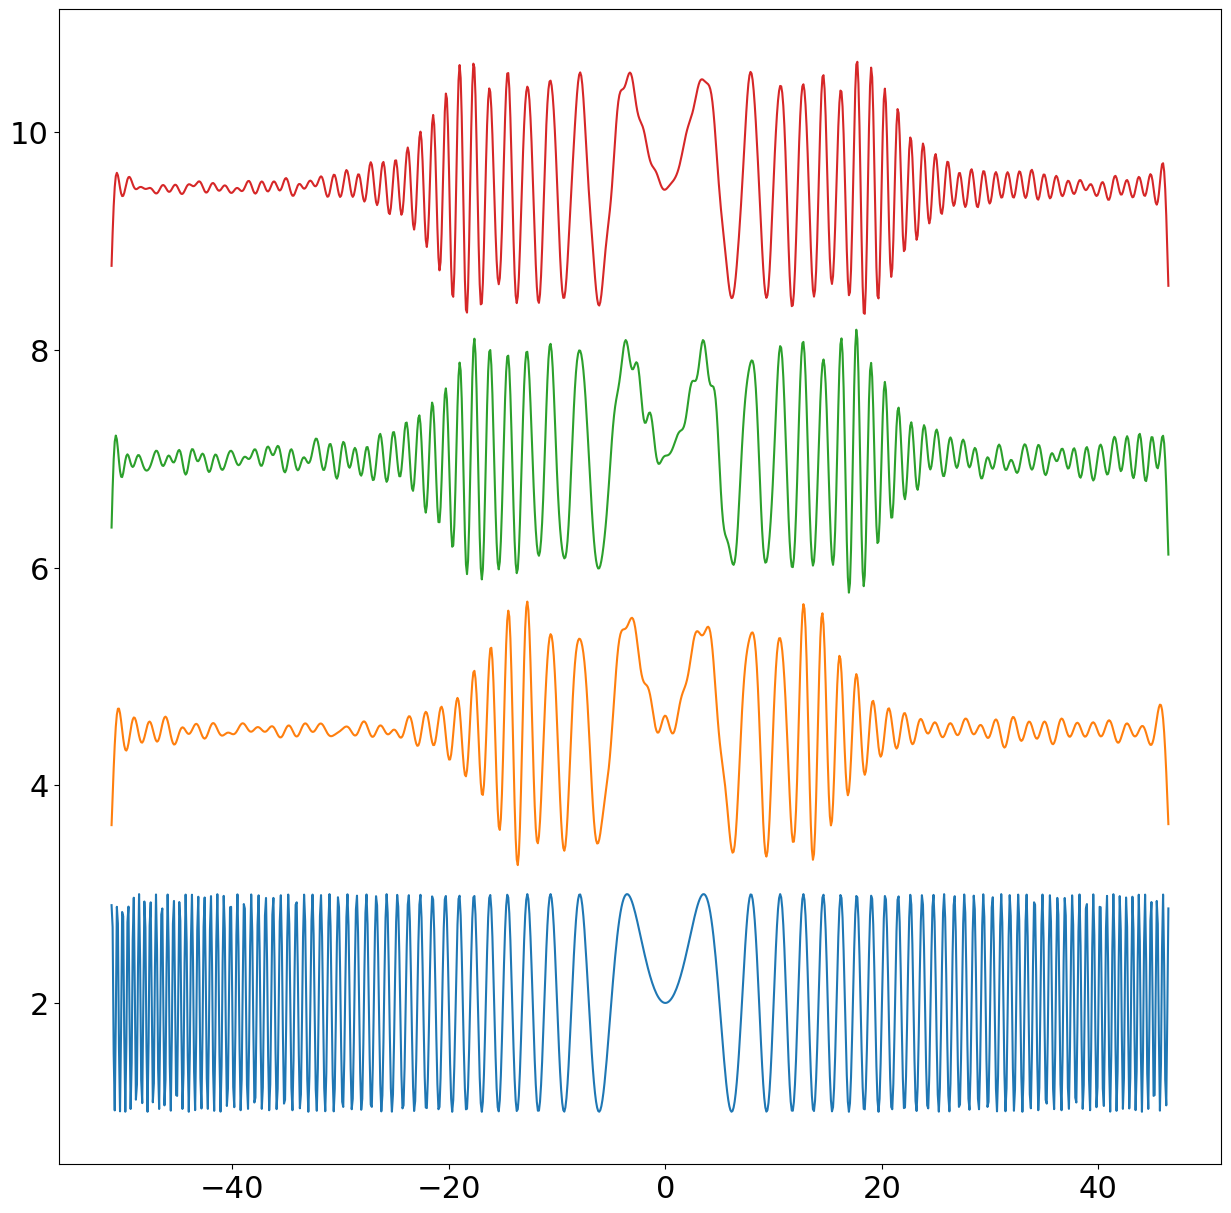

In [ ]:

noise_level = 0.3
plt.figure(figsize=(15,15))
x = np.linspace(-100, 100, 2048)
xin, xout = np.meshgrid(x, x)
f=np.zeros(2048)
f[500:1500]=2+np.sin(2*np.pi*x[500:1500]**2/50.)
plt.plot(x[500:1500],f[500:1500])
plt.plot(x[500:1500],(np.linalg.lstsq(hc,hc@f+np.random.normal(loc=0, scale=noise_level, size=hc.shape[0]),rcond=.3)[0])[500:1500]+2.5)
plt.plot(x[500:1500],(np.linalg.lstsq(hh,hh@f+np.random.normal(loc=0, scale=noise_level, size=hh.shape[0]),rcond=.3)[0])[500:1500]+5)
plt.plot(x[500:1500],(np.linalg.lstsq(hhh,hhh@f+np.random.normal(loc=0, scale=noise_level, size=hhh.shape[0]),rcond=.3)[0])[500:1500]+7.5)
plt.savefig('1DJRecon.pdf')

In [ ]:
pwd

'C:\\Users\\djbrady'

### Conventional vs. Coherence measurement of natural images

We consider a simple system making 16 measurements on a discrete grid of 32 by 32 impulse responses. In the conventional case, the impulse at position $ij$ produces the signature at measurement position $lm$ equal
$$
{\rm sinc}^2({\bf x}_{lm}-{\bf x}_{ij})
$$
In the coherence case the impulse at position $ij$ produces the signature at measurement position $lm$
$$
[{\rm sinc}^2({\bf x}_{lm}-{\bf x}_{ij}),
{\rm sinc}({\bf x}_{lm}-{\bf x}_{ij}){\rm sinc}({\bf x}_{lm}-{\bf x}_{ij}+{\bf 1})]
$$

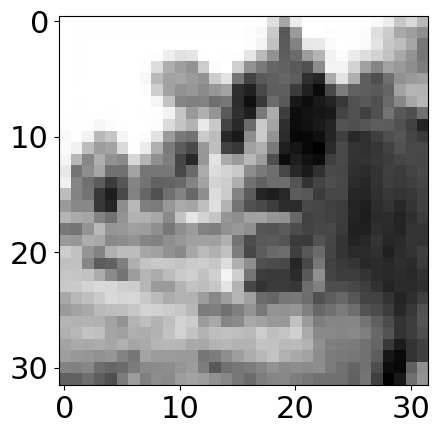

In [ ]:
# prompt: load the cifar100 images as gray scale

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar100

# Load the CIFAR100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# Convert images to grayscale
x_train_gray = np.dot(x_train[...,:3], [0.2989, 0.5870, 0.1140])/255.
x_test_gray = np.dot(x_test[...,:3], [0.2989, 0.5870, 0.1140])/255.

# Now x_train_gray and x_test_gray contain the grayscale images.
# You can use them for your analysis or model training.

# Example: Display a grayscale image
plt.imshow(x_train_gray[0], cmap='gray')
plt.show()

In [ ]:
def conventionalImage(object):
  # object is a 32 by 32 grid of grayscale points. Each point produces a sinc^2 impulse response.
  # measurements are made on a 32 by 32 grid of points, we assume that the spacing is of the object is .5 a
  cI=np.zeros((32,32))
  x=np.linspace(-8,7.5,32)
  xx, yy= np.meshgrid(x,x)
  for i in range(32):
    for j in range(32):
      cI=cI+object[i,j]*(np.sinc(xx-.5*(i-16))*np.sinc(yy-.5*(j-16)))**2
  cI=np.transpose(cI)/np.max(cI)
  return cI


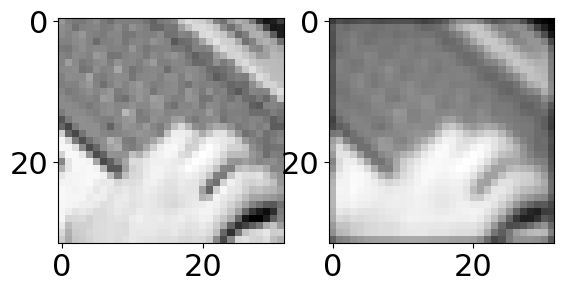

In [ ]:
plt.subplot(1,2,1)
plt.imshow(x_train_gray[10], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(conventionalImage(x_train_gray[10]), cmap='gray')

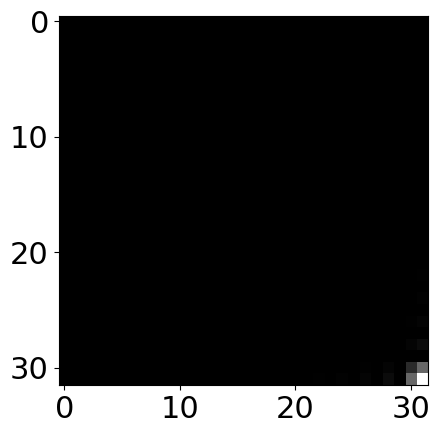

In [ ]:
obj=np.zeros((32,32))
obj[31,31]=1
plt.imshow(conventionalImage(obj), cmap='gray')

In [ ]:
def coherenceImage(object):
  # object is a 32 by 32 grid of grayscale points. Each point produces a sinc^2 and sinc(x)sinc(x+1) impulse response.
  # measurements are made on a 16 by 16 grid of points, we assume that the spacing is of the object is .5 a
  x=np.linspace(-8,7.5,16)
  xx, yy= np.meshgrid(x,x)
  cI=np.zeros(1024)
  for i in range(32):
    for j in range(32):
      # the field due  point target at ij on a 16 by 16 modal sensor array
      field= np.sinc(xx-.5*(i-16))*np.sinc(yy-.5*(j-16))
      # the field is captured into an 8 by 8 grid of 4 mode inteferometers The mutual intensity is the outer product of the 4 modes
      # the outer product consits of 16 values so the number of meaurement is 16x 8x8=  1024 values
      for modexIndex in range(0,16,2):
        for modeyIndex in range(0,16,2):
          fvec=field[modexIndex:(modexIndex+2),modeyIndex:(modeyIndex+2)].flatten()
          fvec=np.outer(fvec,fvec).flatten()
          if modexIndex==0 and modeyIndex==0:
            cIl=fvec
          else:
            cIl=np.vstack((cIl,fvec))
      cI=cI+object[i,j]*cIl.flatten()
  return cI

In [ ]:
4*1024

4096

In [ ]:
x_train_gray.shape

(50000, 32, 32)

In [ ]:


# Generate 1024 random indices between 0 and 50000
images = np.random.randint(0, 50000, size=1024)


# matrix of images
rawImage = np.reshape(x_train_gray[images], (1024,1024))

In [ ]:
rawImage.shape

(1024, 1024)

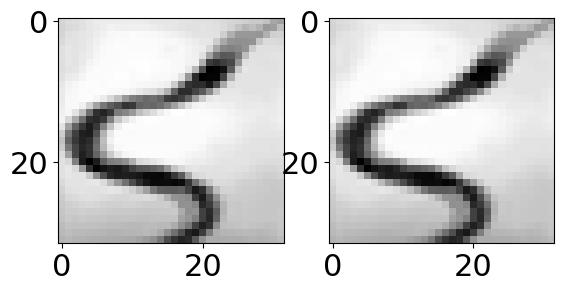

In [ ]:
plt.subplot(1,2,1)
plt.imshow(rawImage[0,:].reshape(32,32), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(x_train_gray[images[0]], cmap='gray')

In [ ]:
pcaRaw=PCA(n_components=256)
pcaRaw.fit(rawImage)

PCA(n_components=256)

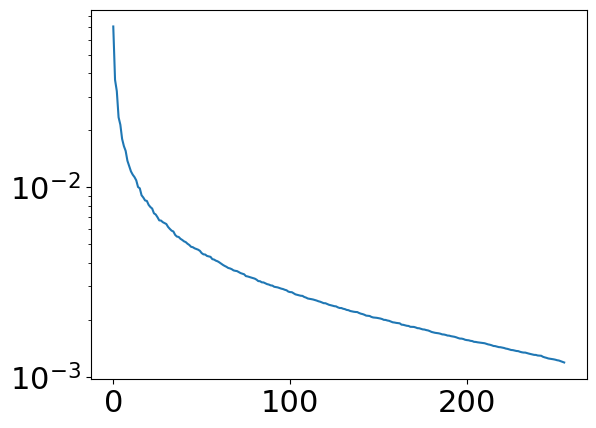

In [ ]:
plt.semilogy(pcaRaw.singular_values_/np.sum(pcaRaw.singular_values_))

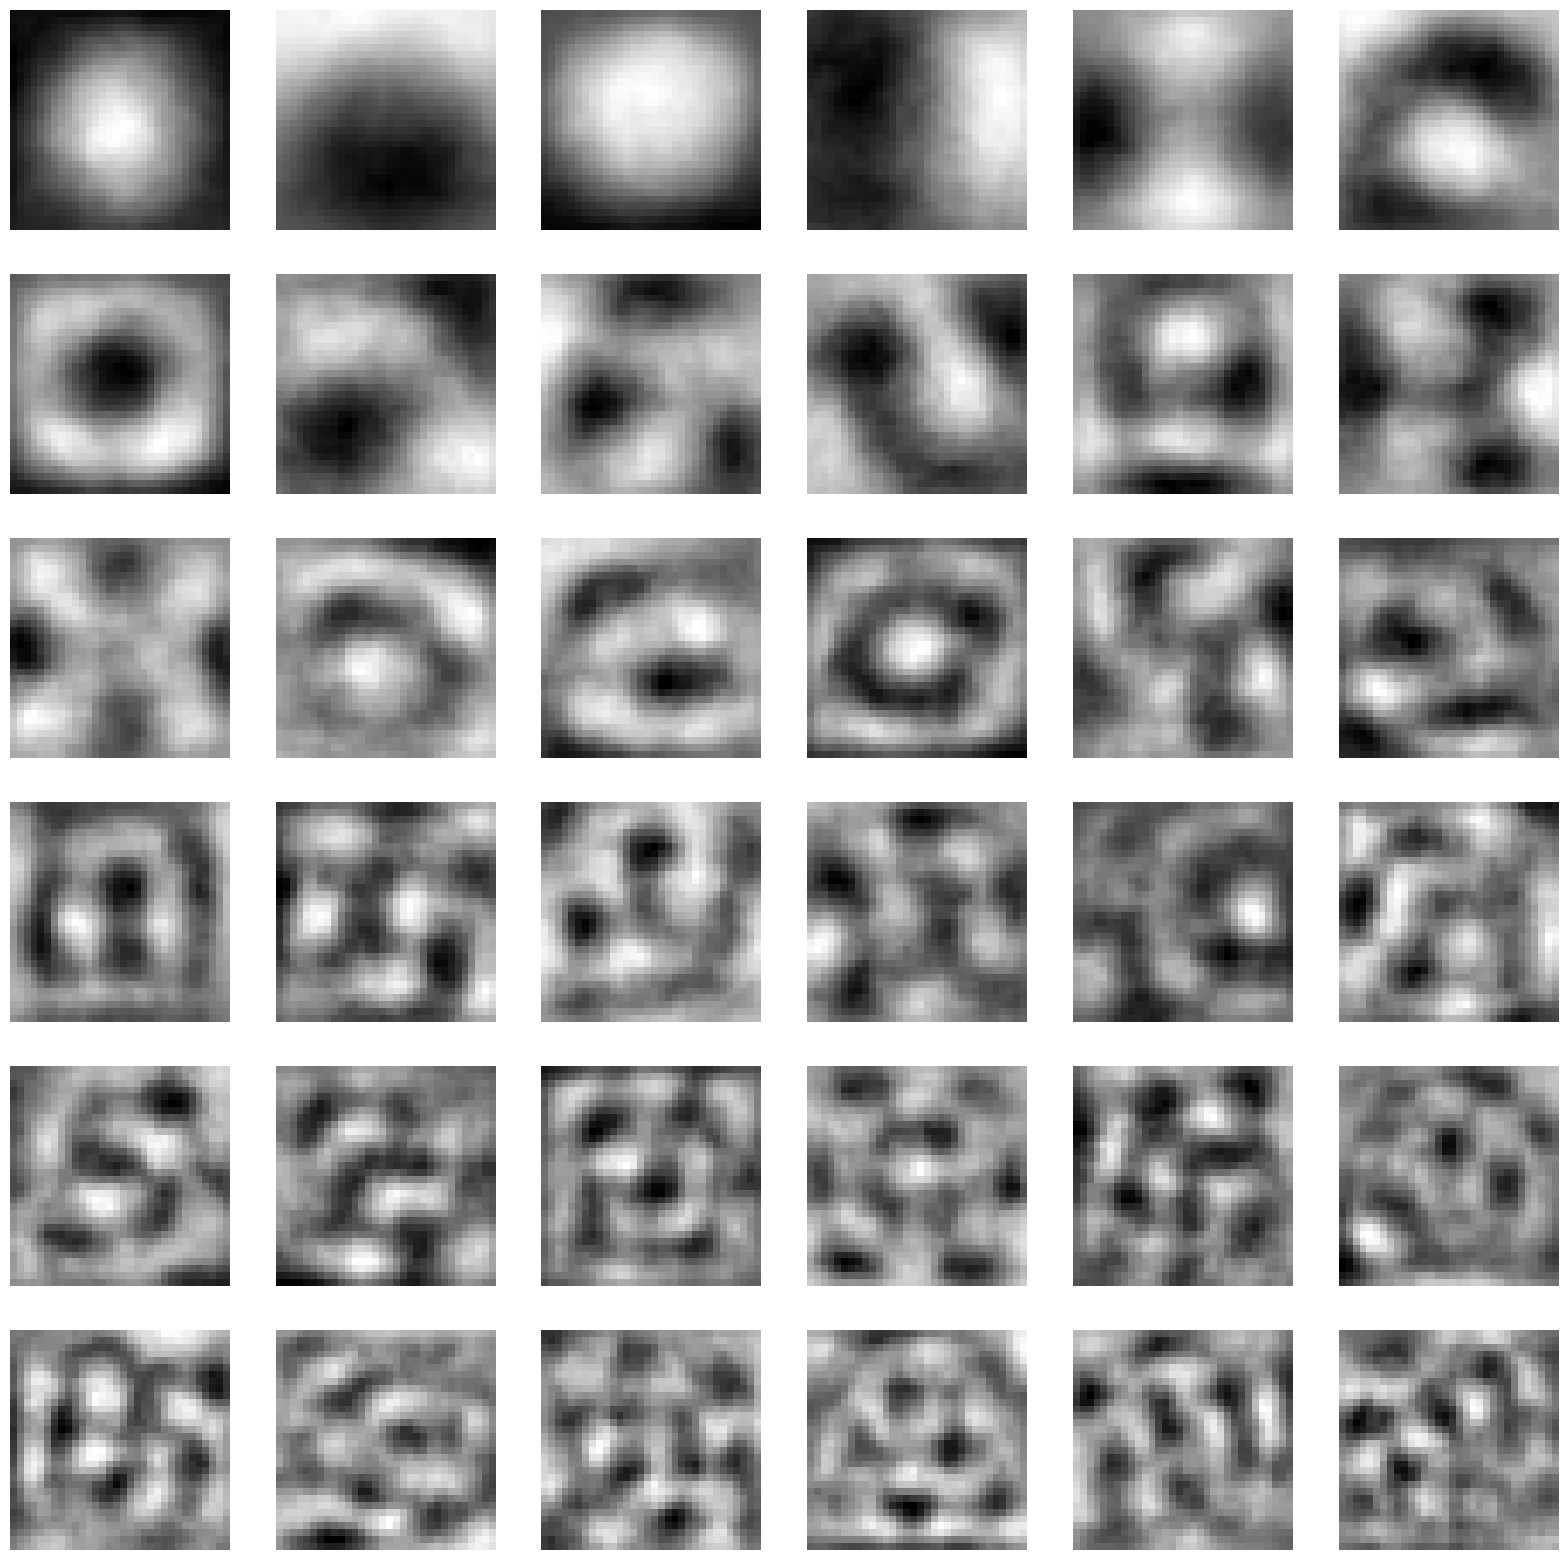

In [ ]:
plt.figure(figsize=(20,20))
for pip in range (36):
    plt.subplot(6,6,pip+1)
    plt.imshow(np.reshape(pcaRaw.components_[pip],(32,32)),cmap='gray')
    plt.axis('off')

In [ ]:



# matrix of conventional focal images
focalImage =np.zeros((1024,1024))
for pip in range(1024):
  focalImage[pip,:] = np.reshape(conventionalImage(x_train_gray[images[pip]]), 1024)

In [ ]:
pcaFocal=PCA(n_components=256)
pcaFocal.fit(focalImage)

PCA(n_components=256)

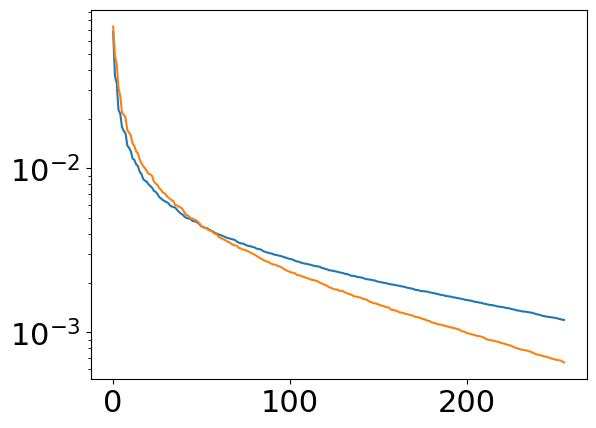

In [ ]:
plt.semilogy(pcaRaw.singular_values_/np.sum(pcaRaw.singular_values_))
plt.semilogy(pcaFocal.singular_values_/np.sum(pcaFocal.singular_values_))

In [ ]:
# matrix of coherence signals
Jimage =np.zeros((1024,1024))
for pip in range(1024):
  Jimage[pip,:] = coherenceImage(x_train_gray[images[pip]])

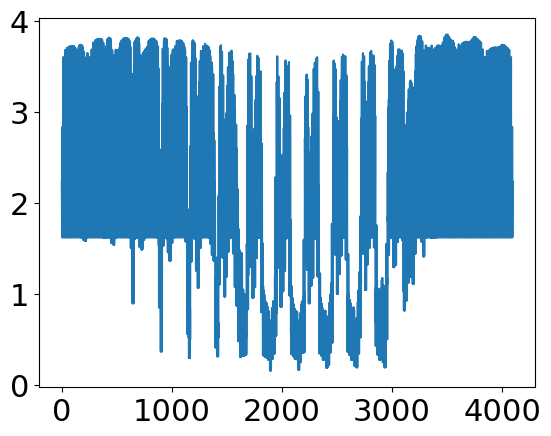

In [ ]:
plt.plot(coherenceImage(x_train_gray[images[100]]))

In [ ]:
pcaJ=PCA(n_components=256)
pcaJ.fit(Jimage)

PCA(n_components=256)

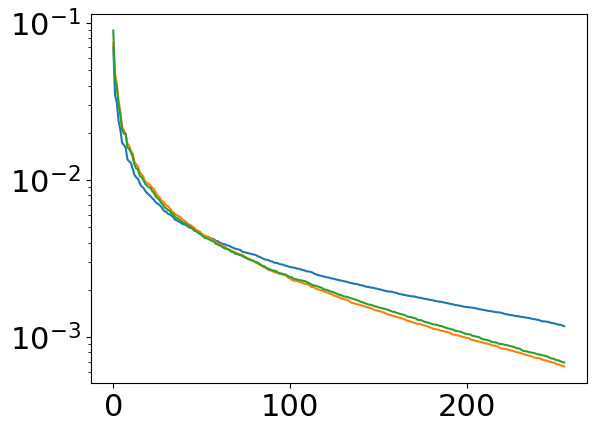

In [ ]:
plt.semilogy(pcaRaw.singular_values_/np.sum(pcaRaw.singular_values_))
plt.semilogy(pcaFocal.singular_values_/np.sum(pcaFocal.singular_values_))
plt.semilogy(pcaJ.singular_values_/np.sum(pcaJ.singular_values_))

### Sampling of finer features

Now let's compare what happens when the period in the 32 by 32 images is $\frac{\lambda f/\#}{8}$, meaning a conventional system draws just $4\times 4$ pixels (corresponding to 16 independent values) and a coherence system takes a single set of inteferometric data from a $2\times 2$ interferometer (corresponding to 10 independent values).

In [ ]:
def conventionalImage(object):
  # object is a 32 by 32 grid of grayscale points. Each point produces a sinc^2 impulse response.
  # measurements are made on a 32 by 32 grid of points, we assume that the spacing is of the object is .125
  cI=np.zeros((32,32))
  x=np.linspace(-2,2,32)
  xx, yy= np.meshgrid(x,x)
  for i in range(32):
    for j in range(32):
      cI=cI+object[i,j]*(np.sinc(xx-.125*(i-16))*np.sinc(yy-.125*(j-16)))**2
  cI=np.transpose(cI)/np.max(cI)
  return cI


In [ ]:
def coherenceImage(object):
  # object is a 32 by 32 grid of grayscale points. Each point produces a sinc^2 and sinc(x)sinc(x+1) impulse response.
  # measurements are made on a 16 by 16 grid of points, we assume that the spacing is of the object is .125 a
  x=np.linspace(-2,2,4)
  xx, yy= np.meshgrid(x,x)
  cI=np.zeros(64)
  for i in range(32):
    for j in range(32):
      # the field due  point target at ij on a 16 by 16 modal sensor array
      field= np.sinc(xx-.125*(i-16))*np.sinc(yy-.1255*(j-16))
      # the field is captured into an 8 by 8 grid of 4 mode inteferometers The mutual intensity is the outer product of the 4 modes
      # the outer product consits of 16 values so the number of meaurement is 16x 8x8=  1024 values
      for modexIndex in range(0,4,2):
        for modeyIndex in range(0,4,2):
          fvec=field[modexIndex:(modexIndex+2),modeyIndex:(modeyIndex+2)].flatten()
          fvec=np.outer(fvec,fvec).flatten()
          if modexIndex==0 and modeyIndex==0:
            cIl=fvec
          else:
            cIl=np.vstack((cIl,fvec))
      cI=cI+object[i,j]*cIl.flatten()
  return cI

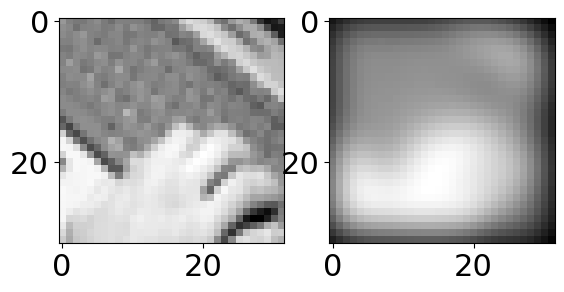

In [ ]:
plt.subplot(1,2,1)
plt.imshow(x_train_gray[10], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(conventionalImage(x_train_gray[10]), cmap='gray')

In [ ]:
# matrix of conventional focal images
focalImage =np.zeros((1024,1024))
for pip in range(1024):
  focalImage[pip,:] = np.reshape(conventionalImage(x_train_gray[images[pip]]), 1024)


PCA(n_components=64)

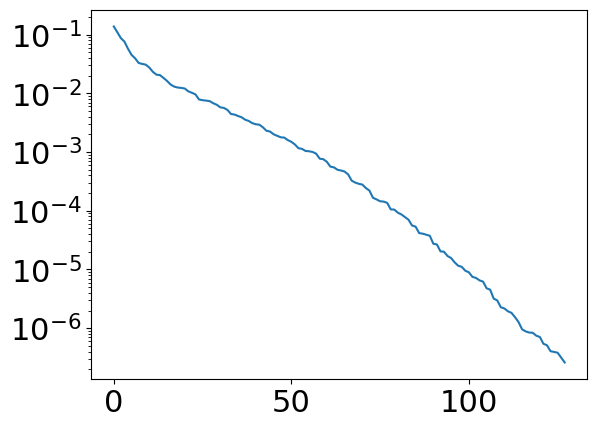

In [ ]:
pcaFocal=PCA(n_components=128)
pcaFocal.fit(focalImage)
plt.semilogy(pcaFocal.singular_values_/np.sum(pcaFocal.singular_values_))

In [ ]:
# matrix of coherence signals
Jimage =np.zeros((1024,64))
for pip in range(1024):
  Jimage[pip,:] = coherenceImage(x_train_gray[images[pip]])

In [ ]:
pcaJ=PCA(n_components=64)
pcaJ.fit(Jimage)

PCA(n_components=64)

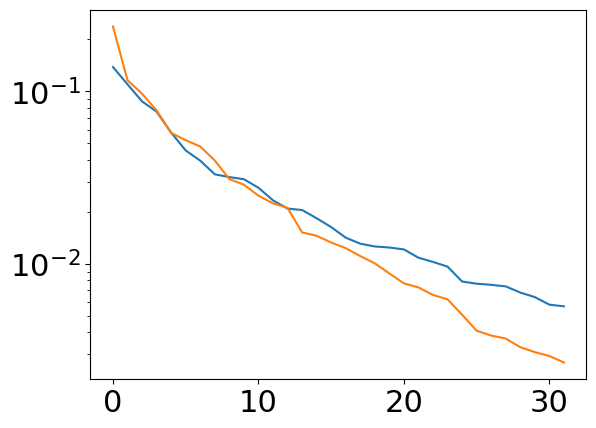

In [ ]:
plt.semilogy(pcaFocal.singular_values_[:32]/np.sum(pcaFocal.singular_values_))
plt.semilogy(pcaJ.singular_values_[:32]/np.sum(pcaJ.singular_values_))

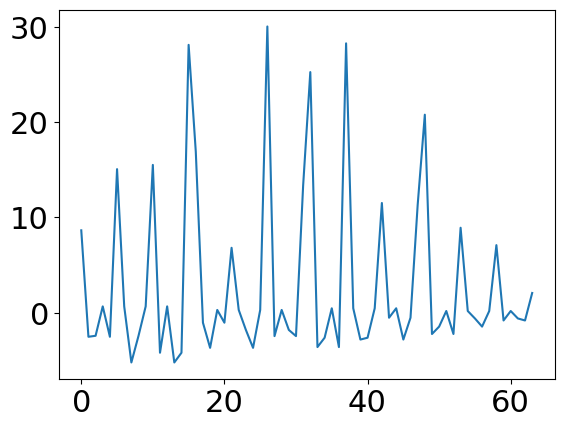

In [ ]:
plt.plot(coherenceImage(x_train_gray[images[109]]))

### same analysis using MNIST digits

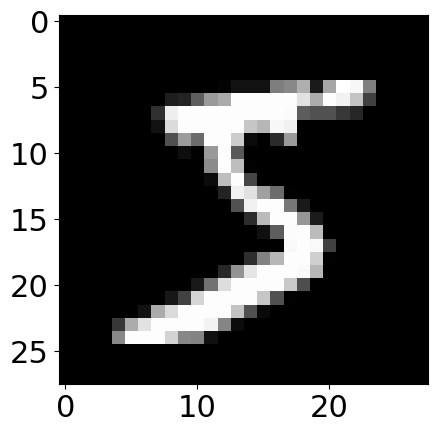

In [ ]:
# prompt: load the MNIST data set

from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Example: Display an image from the training set
plt.imshow(x_train[0], cmap='gray')
plt.show()

In [ ]:
def conventionalImage(object):
  # object is a 28 by 28 grid of grayscale points. Each point produces a sinc^2 impulse response.
  # measurements are made on a 28 by 28 grid of points, we assume that the spacing is of the object is .5 a
  cI=np.zeros((28,28))
  x=np.linspace(-8,8,28)
  xx, yy= np.meshgrid(x,x)
  for i in range(28):
    for j in range(28):
      cI=cI+object[i,j]*(np.sinc(xx-.5*(i-14))*np.sinc(yy-.5*(j-14)))**2
  cI=np.transpose(cI)/np.max(cI)
  return cI


In [ ]:
def coherenceImage(object):
  # object is a 28 by 28 grid of grayscale points. Each point produces a sinc^2 and sinc(x)sinc(x+1) impulse response.
  # measurements are made on a 14 by 14 grid of points, we assume that the spacing is of the object is .5 a
  x=np.linspace(-8,8,16)
  xx, yy= np.meshgrid(x,x)
  cI=np.zeros(784)
  for i in range(28):
    for j in range(28):
      # the field due  point target at ij on a 16 by 16 modal sensor array
      field= np.sinc(xx-.5*(i-16))*np.sinc(yy-.5*(j-16))
      # the field is captured into an 8 by 8 grid of 4 mode inteferometers The mutual intensity is the outer product of the 4 modes
      # the outer product consits of 16 values so the number of meaurement is 16x 8x8=  1024 values
      for modexIndex in range(0,14,2):
        for modeyIndex in range(0,14,2):
          fvec=field[modexIndex:(modexIndex+2),modeyIndex:(modeyIndex+2)].flatten()
          fvec=np.outer(fvec,fvec).flatten()
          if modexIndex==0 and modeyIndex==0:
            cIl=fvec
          else:
            cIl=np.vstack((cIl,fvec))
      cI=cI+object[i,j]*cIl.flatten()
  return cI

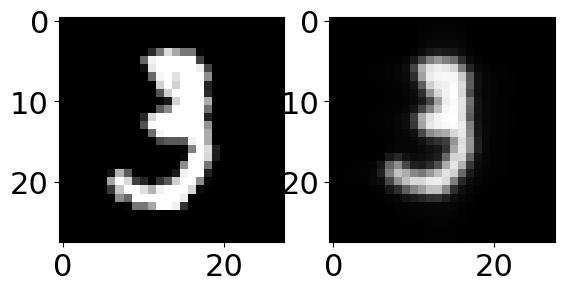

In [ ]:
plt.subplot(1,2,1)
plt.imshow(x_train[10], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(conventionalImage(x_train[10]), cmap='gray')

In [ ]:
# Generate 1024 random indices between 0 and 50000
images = np.random.randint(0, 50000, size=1024)


# matrix of images
rawImage = np.reshape(x_train[images], (1024,784))

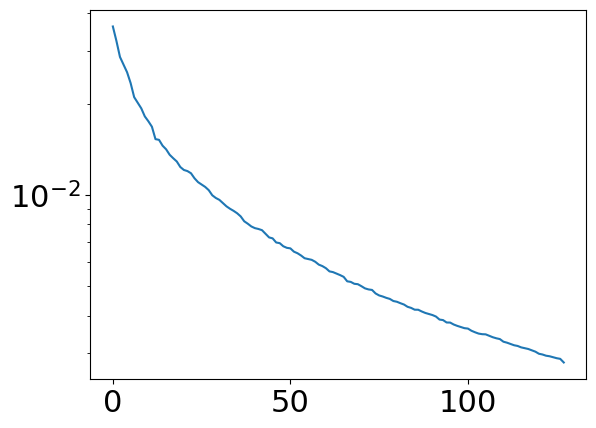

In [ ]:
pcaRaw=PCA(n_components=128)
pcaRaw.fit(rawImage)
plt.semilogy(pcaRaw.singular_values_/np.sum(pcaRaw.singular_values_))

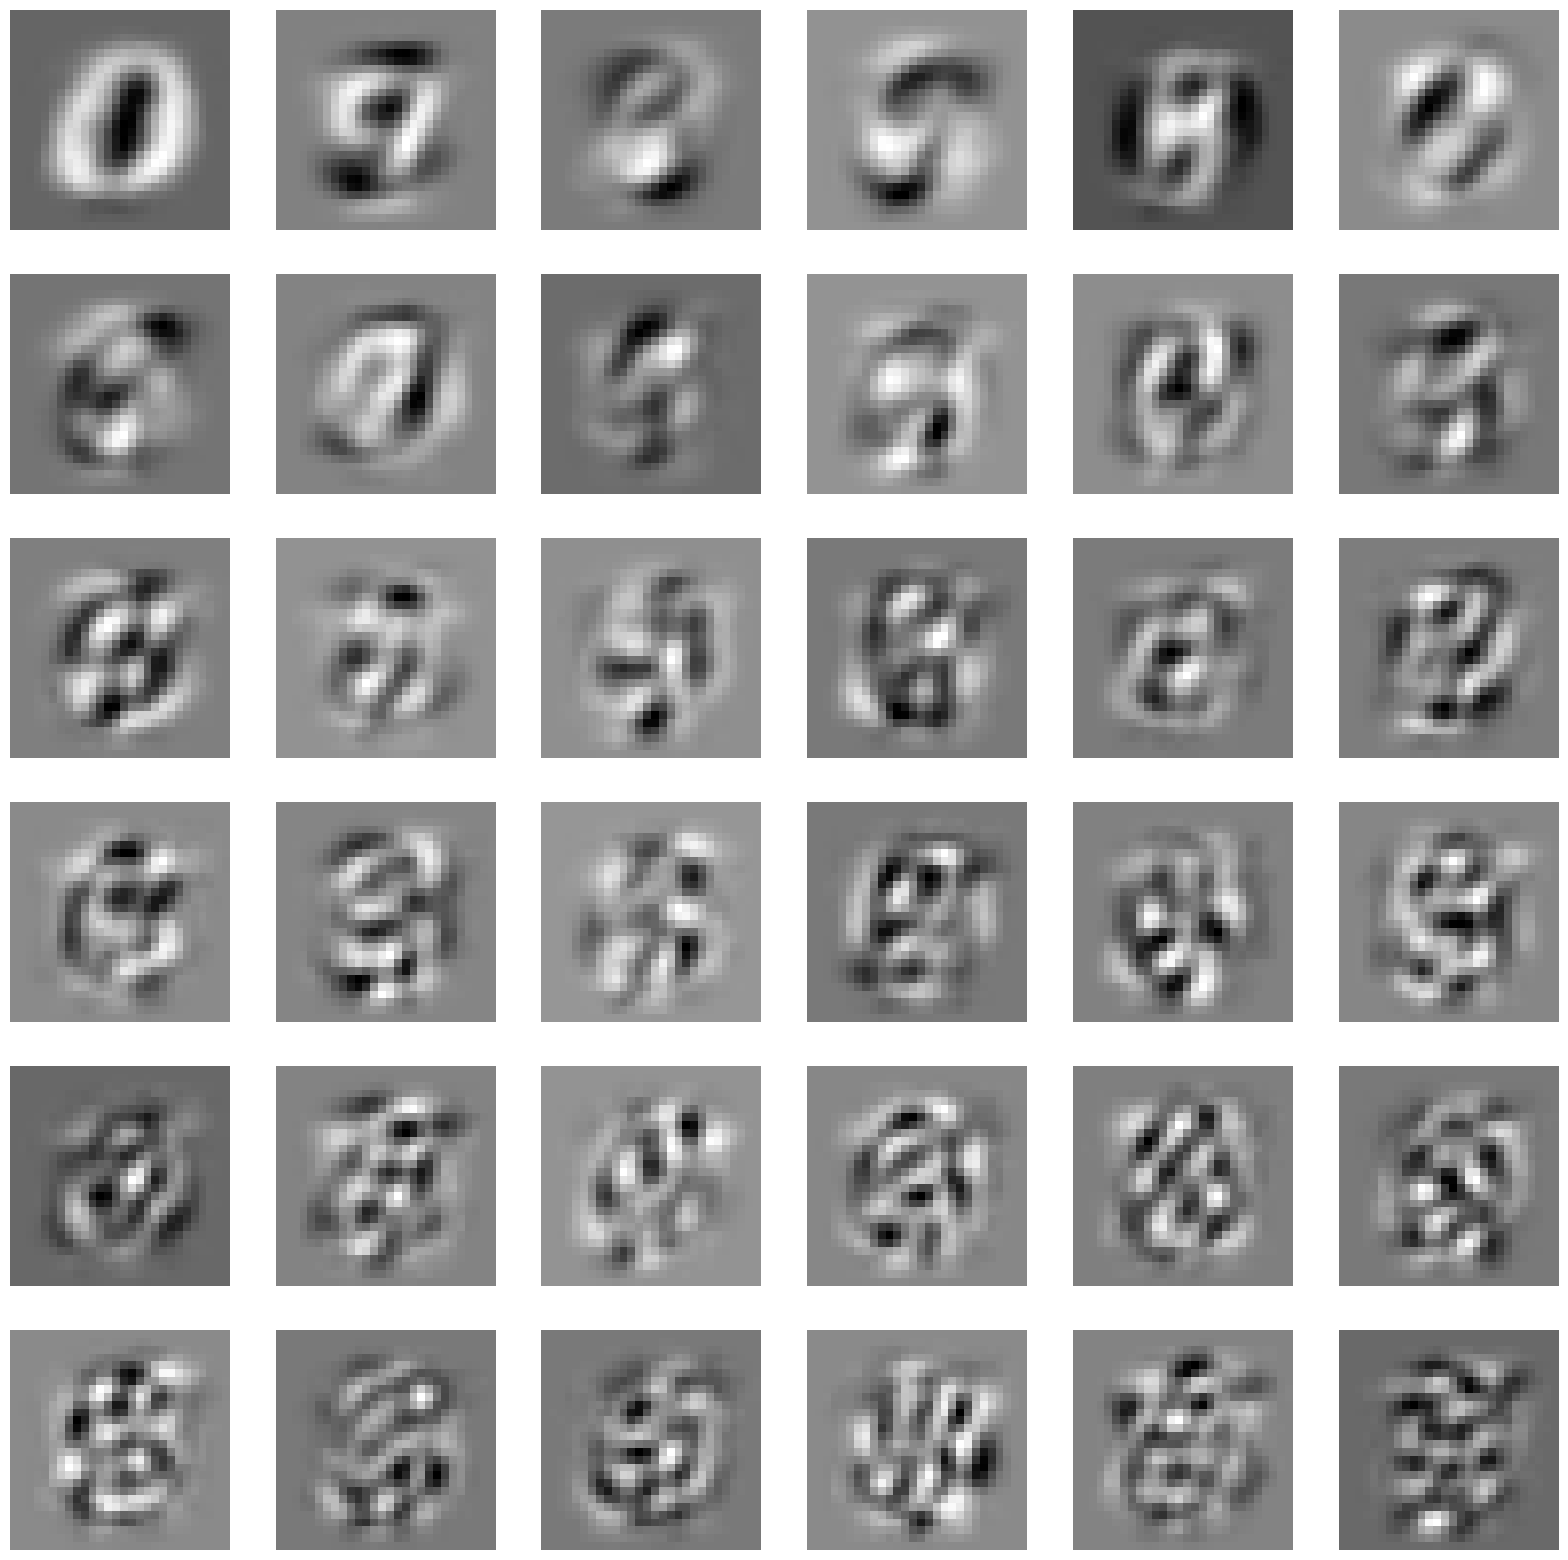

In [ ]:
plt.figure(figsize=(20,20))
for pip in range (36):
    plt.subplot(6,6,pip+1)
    plt.imshow(np.reshape(pcaRaw.components_[pip],(28,28)),cmap='gray')
    plt.axis('off')

In [ ]:



# matrix of conventional focal images
focalImage =np.zeros((1024,784))
for pip in range(1024):
  focalImage[pip,:] = np.reshape(conventionalImage(x_train[images[pip]]), 784)

In [ ]:
pcaFocal=PCA(n_components=128)
pcaFocal.fit(focalImage)

PCA(n_components=128)

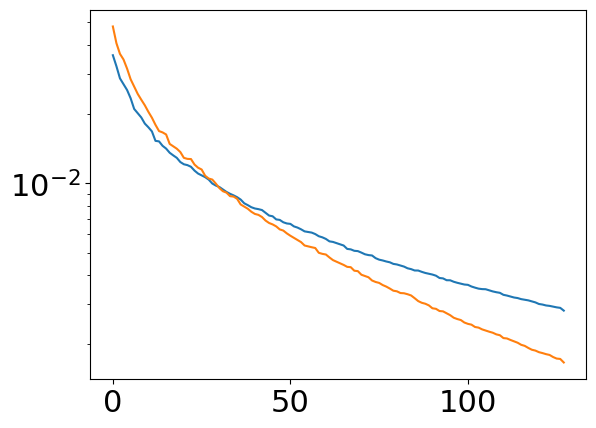

In [ ]:
plt.semilogy(pcaRaw.singular_values_/np.sum(pcaRaw.singular_values_))
plt.semilogy(pcaFocal.singular_values_/np.sum(pcaFocal.singular_values_))

In [ ]:
def coherenceImage(object):
  # object is a 28 by 28 grid of grayscale points. Each point produces a sinc^2 and sinc(x)sinc(x+1) impulse response.
  # measurements are made on a 14 by 14 grid of points, we assume that the spacing is of the object is .5 a
  x=np.linspace(-8,8,16)
  xx, yy= np.meshgrid(x,x)
  cI=np.zeros(784)
  for i in range(28):
    for j in range(28):
      # the field due  point target at ij on a 14 by 14 modal sensor array
      field= np.sinc(xx-.5*(i-14))*np.sinc(yy-.5*(j-14))
      # the field is captured into an 8 by 8 grid of 4 mode inteferometers The mutual intensity is the outer product of the 4 modes
      # the outer product consits of 16 values so the number of meaurement is 16x 8x8=  1024 values
      for modexIndex in range(0,14,2):
        for modeyIndex in range(0,14,2):
          fvec=field[modexIndex:(modexIndex+2),modeyIndex:(modeyIndex+2)].flatten()
          fvec=np.outer(fvec,fvec).flatten()
          if modexIndex==0 and modeyIndex==0:
            cIl=fvec
          else:
            cIl=np.vstack((cIl,fvec))
      cI=cI+object[i,j]*cIl.flatten()
  return cI

In [ ]:
# matrix of coherence signals
Jimage =np.zeros((1024,784))
for pip in range(1024):
  Jimage[pip,:] = coherenceImage(x_train[images[pip]])

In [ ]:
pcaJ=PCA(n_components=128)
pcaJ.fit(Jimage)

PCA(n_components=128)

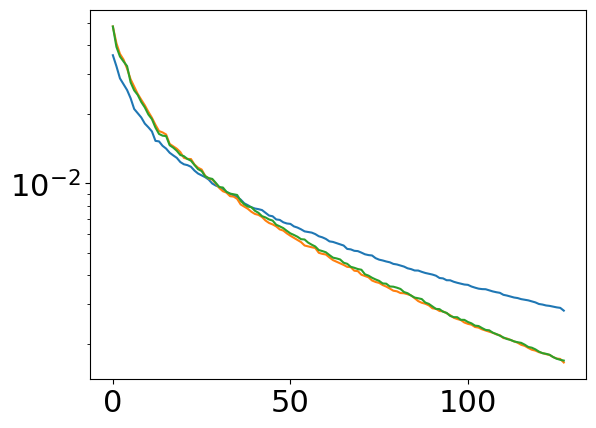

In [ ]:
plt.semilogy(pcaRaw.singular_values_/np.sum(pcaRaw.singular_values_))
plt.semilogy(pcaFocal.singular_values_/np.sum(pcaFocal.singular_values_))
plt.semilogy(pcaJ.singular_values_/np.sum(pcaJ.singular_values_))

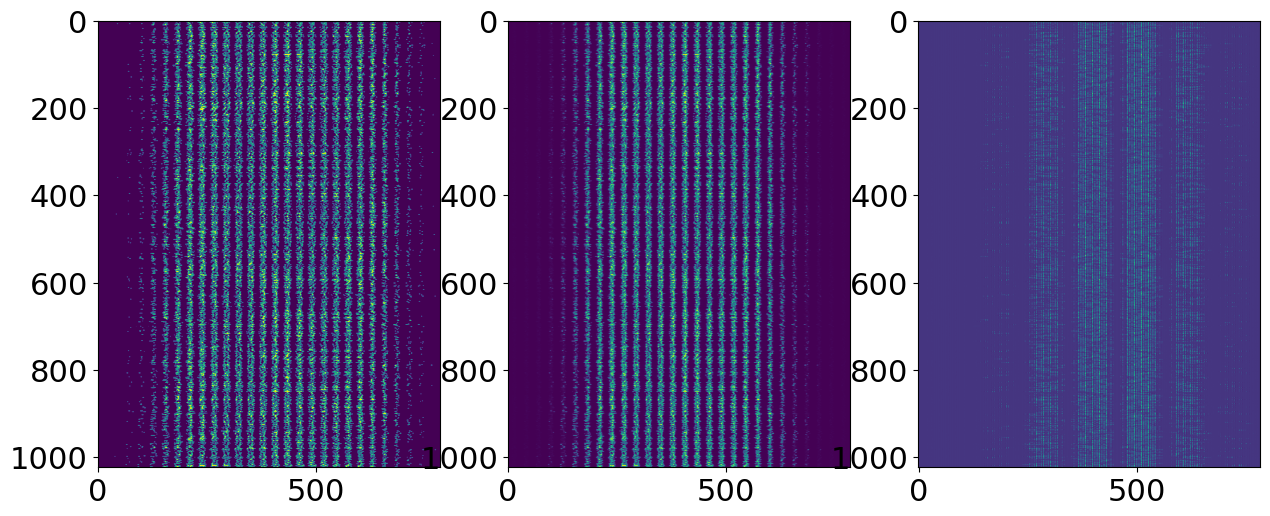

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(rawImage)
plt.subplot(1,3,2)
plt.imshow(focalImage)
plt.subplot(1,3,3)
plt.imshow(Jimage)

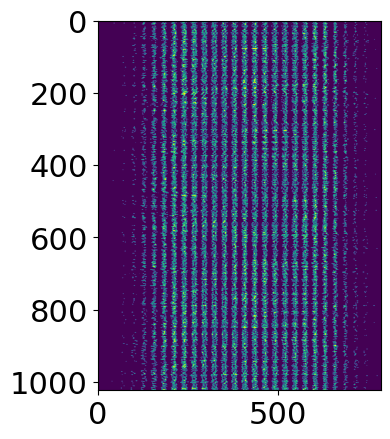

In [ ]:
plt.imshow(rawImage)

## Mutual intensity for example objects

### Mutual intensity of a line



### Definition of the Impulse Response Function

We define the Gaussian impulse response function $ h(x, y) $ with a width parameter $ \sigma = 1 $:

$$
h(x, y) = \frac{1}{2\pi} \exp\left( -\frac{x^2 + y^2}{2} \right)
$$

### Signal

The measurement function $ f(x, y) $ is given by a Dirac delta function representing a line with slope $ \alpha $:

$$
f(x, y) = \delta(x - \alpha y)
$$

### Coherence Function Definition

The coherence function $ j(x_1, y_1, x_2, y_2) $ is defined as:

$$
j(x_1, y_1, x_2, y_2) = \iint f(x, y) \, h(x_1 - x, y_1 - y) \, h(x_2 - x, y_2 - y) \, dx \, dy
$$

### Substituting $ f(x, y) $ into $ j(x_1, y_1, x_2, y_2) $

Substitute $ f(x, y) = \delta(x - \alpha y) $:

$$
j(x_1, y_1, x_2, y_2) = \iint \delta(x - \alpha y) \, h(x_1 - x, y_1 - y) \, h(x_2 - x, y_2 - y) \, dx \, dy
$$

### Integrating Over $ x $

Use the property of the Dirac delta function to integrate over $ x $:

$$
\int_{-\infty}^{\infty} \delta(x - \alpha y) \, h(x_1 - x, y_1 - y) \, h(x_2 - x, y_2 - y) \, dx = h(x_1 - \alpha y, y_1 - y) \, h(x_2 - \alpha y, y_2 - y)
$$

Therefore, the coherence function becomes:

$$
j(x_1, y_1, x_2, y_2) = \int_{-\infty}^{\infty} h(x_1 - \alpha y, y_1 - y) \, h(x_2 - \alpha y, y_2 - y) \, dy
$$

### Substituting the Impulse Response Functions

Substitute the expression for $ h(x, y) $:

$$
h(x_i - \alpha y, y_i - y) = \frac{1}{2\pi} \exp\left( -\frac{(x_i - \alpha y)^2 + (y_i - y)^2}{2} \right), \quad \text{for } i = 1, 2
$$

Thus, the coherence function becomes:

$$
j(x_1, y_1, x_2, y_2) = \frac{1}{(2\pi)^2} \int_{-\infty}^{\infty} \exp\left( -\frac{(x_1 - \alpha y)^2 + (y_1 - y)^2 + (x_2 - \alpha y)^2 + (y_2 - y)^2}{2} \right) dy
$$

### Simplifying the Exponent

Expand the terms in the exponent:

$$
\begin{align*}
& (x_1 - \alpha y)^2 + (y_1 - y)^2 + (x_2 - \alpha y)^2 + (y_2 - y)^2 \\
= & \left[ x_1^2 - 2\alpha x_1 y + \alpha^2 y^2 \right] + \left[ y_1^2 - 2 y_1 y + y^2 \right] \\
  & + \left[ x_2^2 - 2\alpha x_2 y + \alpha^2 y^2 \right] + \left[ y_2^2 - 2 y_2 y + y^2 \right] \\
= & (x_1^2 + x_2^2 + y_1^2 + y_2^2) - 2 y (\alpha x_1 + \alpha x_2 + y_1 + y_2) + (2 \alpha^2 + 2) y^2
\end{align*}
$$

### Completing the Square in $ y $

Let:

$$
A = 2 \alpha^2 + 2 = 2 (\alpha^2 + 1)
$$

$$
B = 2 (\alpha x_1 + \alpha x_2 + y_1 + y_2)
$$

Now, rewrite the exponent in terms of $ y $:

$$
\text{Exponent} = \frac{1}{2} \left[ (x_1^2 + x_2^2 + y_1^2 + y_2^2) - B y + A y^2 \right]
$$

Complete the square:

$$
A y^2 - B y = A \left( y - \frac{B}{2A} \right)^2 - \frac{B^2}{4A}
$$

Thus, the exponent becomes:

$$
\text{Exponent} = \frac{1}{2} \left[ (x_1^2 + x_2^2 + y_1^2 + y_2^2) - \frac{B^2}{4A} + A \left( y - \frac{B}{2A} \right)^2 \right]
$$

Simplify:

$$
\text{Exponent} = \frac{1}{2} \left( (x_1^2 + x_2^2 + y_1^2 + y_2^2) - \frac{(\alpha x_1 + \alpha x_2 + y_1 + y_2)^2}{2(\alpha^2 + 1)} + 2(\alpha^2 + 1) \left( y - \frac{\alpha x_1 + \alpha x_2 + y_1 + y_2}{2(\alpha^2 + 1)} \right)^2 \right)
$$

### Evaluating the Integral Over $ y $

Now, the integral becomes:

$$
j(x_1, y_1, x_2, y_2) = \frac{1}{(2\pi)^2} \exp\left( -\frac{1}{2} \left( x_1^2 + x_2^2 + y_1^2 + y_2^2 - \frac{(\alpha x_1 + \alpha x_2 + y_1 + y_2)^2}{2(\alpha^2 + 1)} \right) \right) \int_{-\infty}^{\infty} \exp\left( -(\alpha^2 + 1) \left( y - \mu \right)^2 \right) dy
$$

Where:

$$
\mu = \frac{\alpha x_1 + \alpha x_2 + y_1 + y_2}{2(\alpha^2 + 1)}
$$

The integral over $ y $ is a Gaussian integral:

$$
\int_{-\infty}^{\infty} \exp\left( -(\alpha^2 + 1) \left( y - \mu \right)^2 \right) dy = \sqrt{ \frac{\pi}{\alpha^2 + 1} }
$$

### Final Expression for $ j(x_1, y_1, x_2, y_2) $

Combining all the terms:

$$
j(x_1, y_1, x_2, y_2) = \frac{1}{(2\pi)^2} \sqrt{ \frac{\pi}{\alpha^2 + 1} } \exp\left( -\frac{x_1^2 + x_2^2 + y_1^2 + y_2^2}{2} + \frac{ (\alpha x_1 + \alpha x_2 + y_1 + y_2)^2 }{ 4 (\alpha^2 + 1) } \right)
$$

Simplify the constants:

$$
j(x_1, y_1, x_2, y_2) = \frac{1}{2\pi \sqrt{ 2\pi (\alpha^2 + 1) } } \exp\left( -\frac{x_1^2 + x_2^2 + y_1^2 + y_2^2}{2} + \frac{ (\alpha x_1 + \alpha x_2 + y_1 + y_2)^2 }{ 4 (\alpha^2 + 1) } \right)
$$

### Special Case: $ x_1 = x_2 = x $ and $ y_1 = y_2 = y $

When $ x_1 = x_2 = x $ and $ y_1 = y_2 = y $, the coherence function simplifies:

$$
j(x, y, x, y) = \frac{1}{2\pi \sqrt{ 2\pi (\alpha^2 + 1) } } \exp\left( - ( x^2 + y^2 ) + \frac{ (2\alpha x + 2 y)^2 }{ 4 (\alpha^2 + 1) } \right)
$$

Simplify the exponent:

$$
\begin{align*}
- ( x^2 + y^2 ) + \frac{ (2\alpha x + 2 y)^2 }{ 4 (\alpha^2 + 1) } & = - ( x^2 + y^2 ) + \frac{ 4 ( \alpha x + y )^2 }{ 4 (\alpha^2 + 1) } \\
& = - ( x^2 + y^2 ) + \frac{ ( \alpha x + y )^2 }{ \alpha^2 + 1 }
\end{align*}
$$

Compute the exponent further:

$$
- ( x^2 + y^2 ) + \frac{ ( \alpha x + y )^2 }{ \alpha^2 + 1 } = - \frac{ ( x^2 + y^2 )( \alpha^2 + 1 ) }{ \alpha^2 + 1 } + \frac{ ( \alpha x + y )^2 }{ \alpha^2 + 1 } = - \frac{ [ x^2 + y^2 ] ( \alpha^2 + 1 ) - ( \alpha x + y )^2 }{ \alpha^2 + 1 }
$$

Simplify the numerator:

$$
( \alpha^2 + 1 )( x^2 + y^2 ) - ( \alpha x + y )^2 = \alpha^2 x^2 + x^2 + \alpha^2 y^2 + y^2 - \left( \alpha^2 x^2 + 2 \alpha x y + y^2 \right)
$$

Simplify further:

$$
\left( \alpha^2 x^2 + x^2 + \alpha^2 y^2 + y^2 \right) - \left( \alpha^2 x^2 + 2 \alpha x y + y^2 \right) = x^2 - 2 \alpha x y + \alpha^2 y^2 = ( x - \alpha y )^2
$$

Therefore, the exponent simplifies to:

$$
- \frac{ ( x - \alpha y )^2 }{ \alpha^2 + 1 }
$$

Thus, the coherence function simplifies to:

$$
j(x, y, x, y) = \frac{1}{2\pi \sqrt{ 2\pi (\alpha^2 + 1) } } \exp\left( - \frac{ ( x - \alpha y )^2 }{ \alpha^2 + 1 } \right)
$$

### Interpretation

- The coherence function $ j(x, y, x, y) $ is maximized along the line $ x = \alpha y $, which corresponds to the support of the measurement function $ f(x, y) = \delta(x - \alpha y) $.
- The function $ j(x, y, x, y) $ represents a Gaussian profile perpendicular to the line $ x = \alpha y $, with a width determined by $ \alpha^2 + 1 $.



In [ ]:


def j(x1, y1, x2, y2, alpha):
    """
    Computes the coherence function j(x1, y1, x2, y2) for given positions and parameter alpha.

    Parameters:
    x1, y1, x2, y2 : float or np.ndarray
        Coordinates at which to evaluate the coherence function.
    alpha : float
        The parameter alpha in the function f(x, y) = delta(x - alpha y).

    Returns:
    j_value : float or np.ndarray
        The value of the coherence function at the given coordinates.
    """
    # Ensure inputs are NumPy arrays for element-wise operations
    x1 = np.array(x1)
    y1 = np.array(y1)
    x2 = np.array(x2)
    y2 = np.array(y2)
    alpha = np.array(alpha)

    # Constants
    a_squared_plus_one = alpha**2 + 1
    sqrt_term = np.sqrt(2 * np.pi * a_squared_plus_one)
    prefactor = 1 / (2 * np.pi * sqrt_term)

    # Compute the exponent terms
    exponent1 = - (x1**2 + x2**2 + y1**2 + y2**2) / 2
    numerator = (alpha * x1 + alpha * x2 + y1 + y2)**2
    denominator = 4 * a_squared_plus_one
    exponent2 = numerator / denominator

    # Total exponent
    exponent = exponent1 + exponent2

    # Compute the coherence function
    j_value = prefactor * np.exp(exponent)
    return j_value


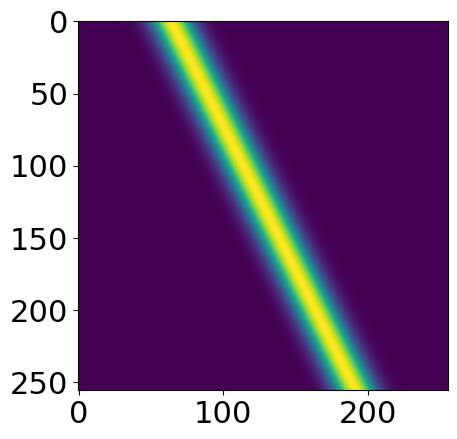

In [ ]:
x=np.linspace(-10,10,256)
xx, yy= np.meshgrid(x,x)
plt.imshow(j(xx,yy,xx,yy,.5))

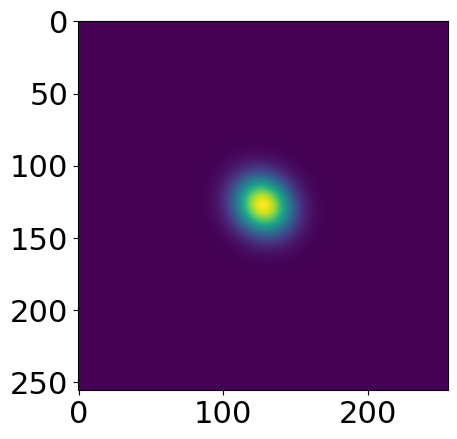

In [ ]:
x=np.linspace(-10,10,256)
xx, yy= np.meshgrid(x,x)
plt.imshow(j(xx,0,yy,0,.5))